In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import scanpy as sc
import sys

In [2]:
sys.path.append("./echidna/")

In [2]:
import echidna as ec
ec.pl.activate_plot_settings()

In [3]:
mets = sc.read_h5ad("METS_all_cells.h5ad")
mets.var_names_make_unique()

/Users/joyfan/miniconda3/envs/decipher-env/lib/python3.11/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [4]:
mets = mets[mets.obs["tumor_nontumor_minor_refined"]=="Cancer cells"]

In [5]:
primary = sc.read_h5ad("PRIMARY_all_cells.h5ad")
primary = primary[primary.obs["tumor_nontumor_minor_refined"]=="Cancer cells"]

In [6]:
primary.X = primary.layers["counts"]
mets.X = mets.layers["counts"]
primary.obs["timepoint"]=["primary" for i in range(primary.shape[0])]
mets.obs["timepoint"]=["mets" for i in range(mets.shape[0])]

/var/folders/ls/bynfxvkd45n7qyly8qv285pm0000gn/T/ipykernel_39546/3303541707.py:3: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  primary.obs["timepoint"]=["primary" for i in range(primary.shape[0])]
/var/folders/ls/bynfxvkd45n7qyly8qv285pm0000gn/T/ipykernel_39546/3303541707.py:4: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  mets.obs["timepoint"]=["mets" for i in range(mets.shape[0])]


In [7]:
adata = primary.concatenate(mets)

/var/folders/ls/bynfxvkd45n7qyly8qv285pm0000gn/T/ipykernel_39546/3683981965.py:1: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata = primary.concatenate(mets)


In [8]:
primaryw = pd.read_csv("Primary_Wdf.csv",index_col='0').drop("Unnamed: 0", axis=1)
metw = pd.read_csv("Mets_Wdf.csv",index_col='0').drop("Unnamed: 0", axis=1)

In [9]:
wdf = pd.concat((primaryw, metw), axis=1)

In [10]:
wdf.columns = ["primary","mets"]

In [11]:
wdf = wdf.loc[np.intersect1d(metw.index, adata.var_names)]
adata = adata[:, np.intersect1d(metw.index, adata.var_names)]

In [12]:
adata.layers["counts"] = adata.X
sc.pp.calculate_qc_metrics(adata, inplace=True)
adata.obs['original_total_counts'] = adata.obs['total_counts']

# log10 original library size
adata.obs['log10_original_total_counts'] = np.log10(adata.obs['original_total_counts'])

# Normalize by median library size
med = np.median(adata.obs['original_total_counts'])
sc.pp.normalize_total(adata, target_sum = med)
sc.pp.log1p(adata)

/var/folders/ls/bynfxvkd45n7qyly8qv285pm0000gn/T/ipykernel_39546/4040235861.py:1: ImplicitModificationWarning: Setting element `.layers['counts']` of view, initializing view as actual.
  adata.layers["counts"] = adata.X


In [13]:
sc.pp.neighbors(adata)

         Falling back to preprocessing with `sc.pp.pca` and default params.


/Users/joyfan/miniconda3/envs/decipher-env/lib/python3.11/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


In [14]:
sc.tl.leiden(adata)
sc.tl.umap(adata)

/var/folders/ls/bynfxvkd45n7qyly8qv285pm0000gn/T/ipykernel_39546/3341371877.py:1: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata)


... storing 'timepoint' as categorical


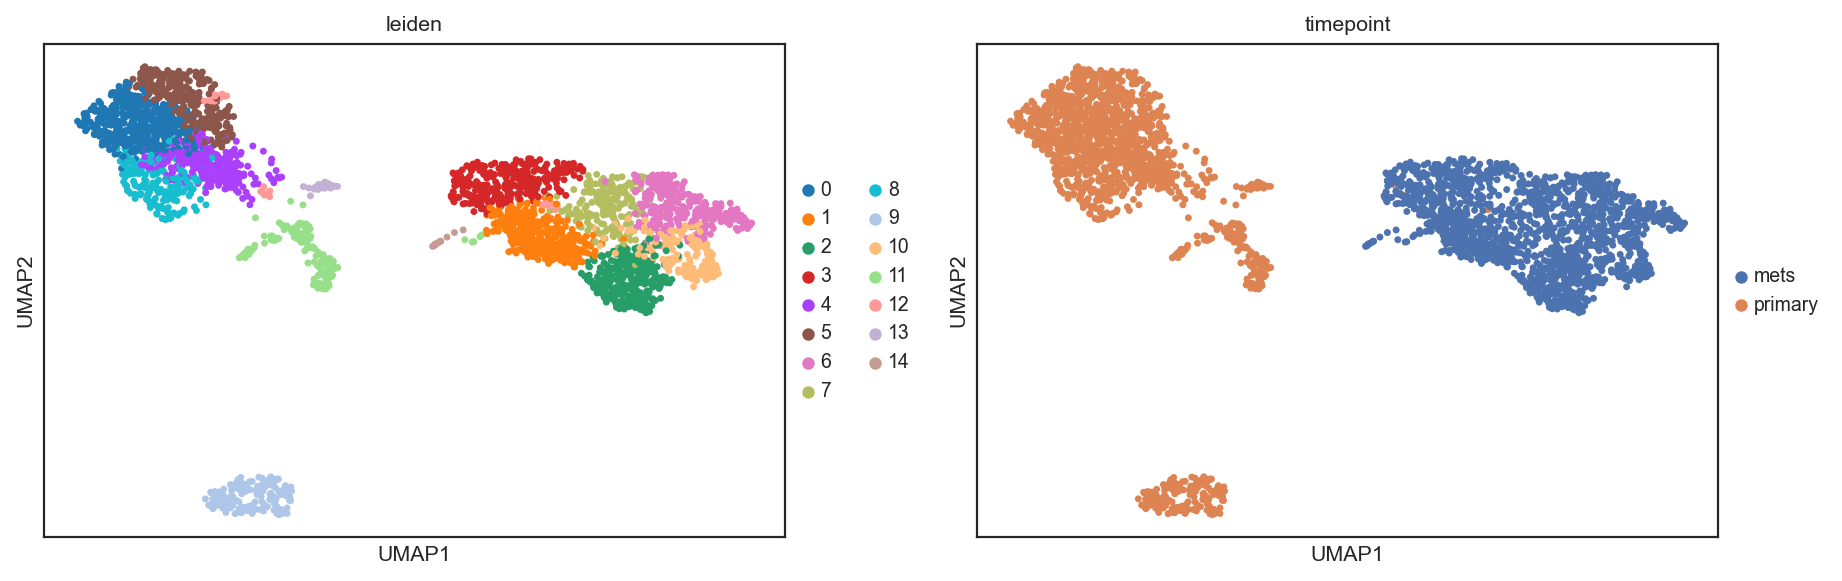

In [15]:
sc.pl.umap(adata,color=["leiden","timepoint"])

In [16]:
ec.tl.set_sort_order(
    adata,
    ["primary", "mets"]
)

In [17]:
adata.layers["counts"] = adata.layers["counts"].toarray()

2025-07-11 10:43:44,838 | INFO : Added `.obs['echidna_split']`: the Echidna train/validation split.
 150 cells in validation set.
2025-07-11 10:43:44,843 | INFO : Added `.var[echidna_matched_genes]` : Labled True for genes contained in W.
2025-07-11 10:43:44,848 | INFO : Added `.var[echidna_W_primary]` : CN entries for genes contained in W.
2025-07-11 10:43:44,849 | INFO : Added `.var[echidna_W_mets]` : CN entries for genes contained in W.
2025-07-11 10:43:44,849 | WARNING : `leiden` changed to `leiden_categorical`.
/Users/joyfan/miniconda3/envs/decipher-env/lib/python3.11/site-packages/echidna/tools/train.py:74: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0 8 0 ... 1 3 1]' has dtype incompatible with category, please explicitly cast to a compatible dtype first.
  adata.obs.loc[:, config.clusters] = pd.Categorical(adata.obs.loc[:,config.clusters]).codes
training loss: 1.1232 | validation loss: 0.1965: 100%|█████

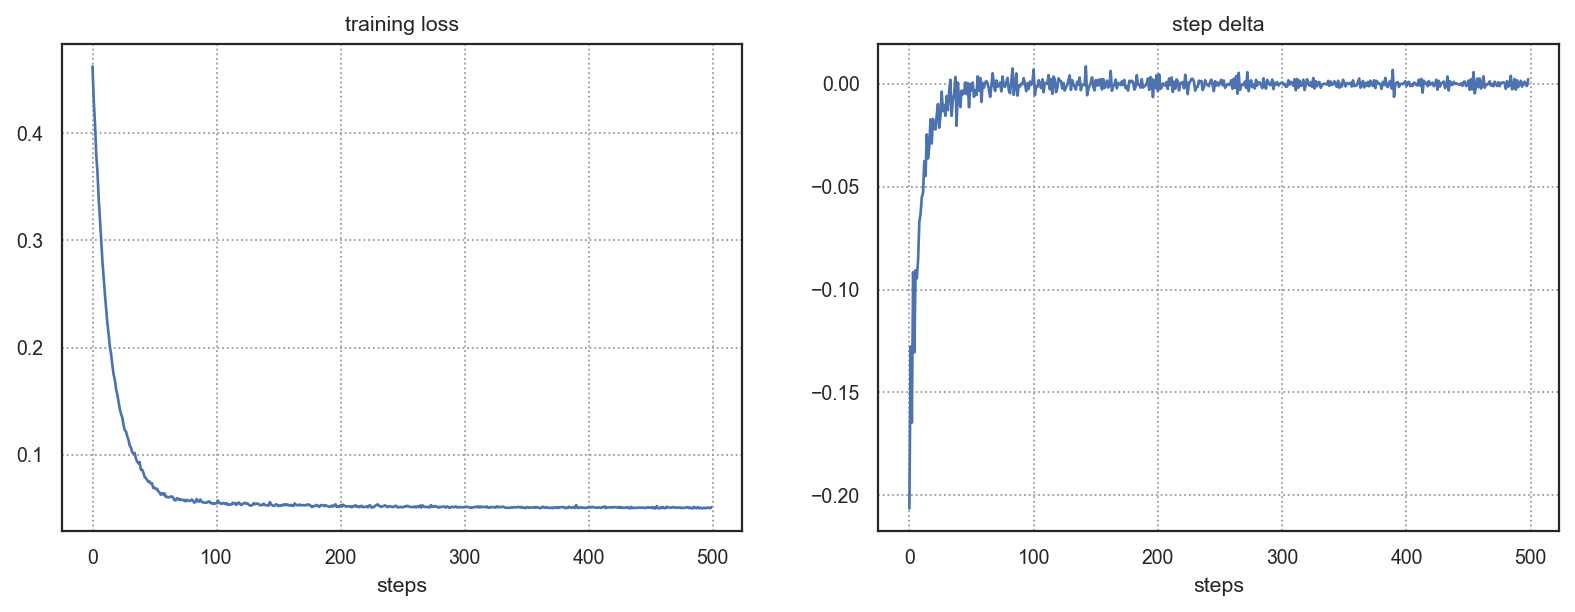

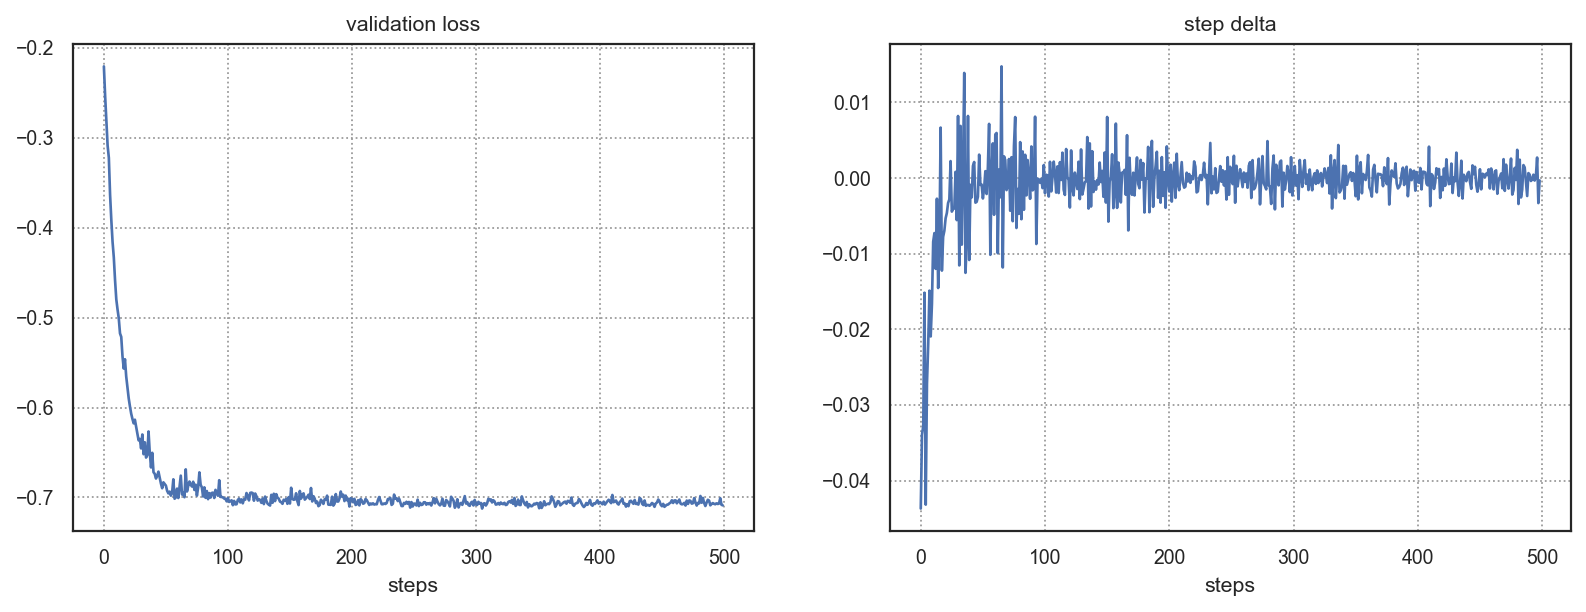

2025-07-11 10:51:12,415 | INFO : Saving echidna model with run_id 20250711-105112.


In [18]:
config = ec.tl.EchidnaConfig(
    timepoint_label = "timepoint", # `assert 'timepoint' in adata.obs.columns`
    counts_layer = "counts", # `assert 'counts' in list(adata.layers.keys())`
    clusters = "leiden", # `assert 'leiden' in adata.obs.columns`
    inverse_gamma = False, # Inverse Gamma False when we have more data
    patience = None, # Increase/decrease to affect early stopping, None for no early stopping (default)
    n_steps = 500,
    val_split = .1,
    learning_rate = .1,
    q_corr_init = 1e-2, # See README.md for model hyperparam descriptions
    q_shape_rate_scaler = 10.0,
    eta_mean_init = 2.0,
    lkj_concentration = 1.0,
)
ec.tl.echidna_train(
     adata # Single-cell AnnData
    , wdf # Copy number  pd.DataFrame, indexed with genes
    , config # Config settings
)

In [19]:
ec.tl.echidna_clones(adata, threshold=0.3)

/Users/joyfan/miniconda3/envs/decipher-env/lib/python3.11/site-packages/echidna/tools/eval.py:356: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hier_colors = [color_dict.loc[int(i)][0] for i in adata.obs[cluster_label]]
2025-07-11 10:51:12,692 | INFO : Added `.obs['echidna_clones']`: the learned clones from eta.


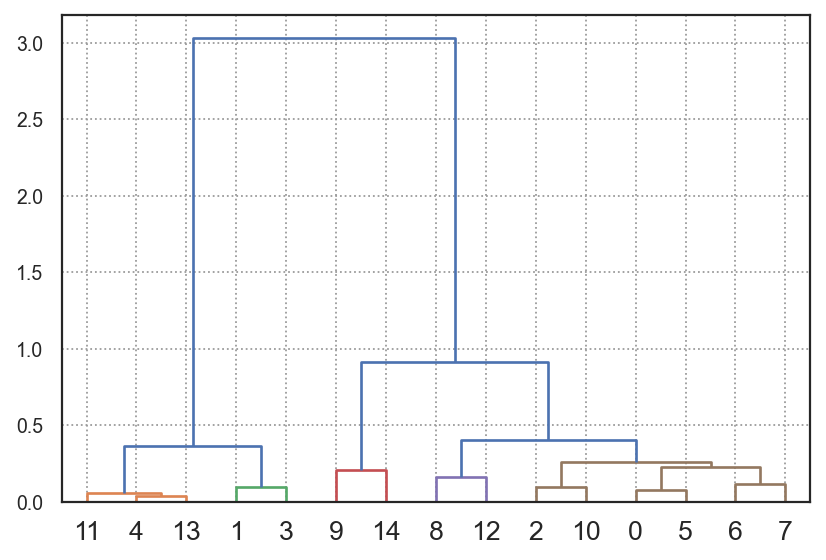

In [21]:
ec.pl.dendrogram(adata)

In [22]:
plt.rcParams.update({'font.size': 15})
plt.rcParams.update({'axes.labelsize' : 'large'}) 
plt.rcParams.update({'axes.titlesize' : 20}) 
plt.rcParams.update({'legend.fontsize': 15})

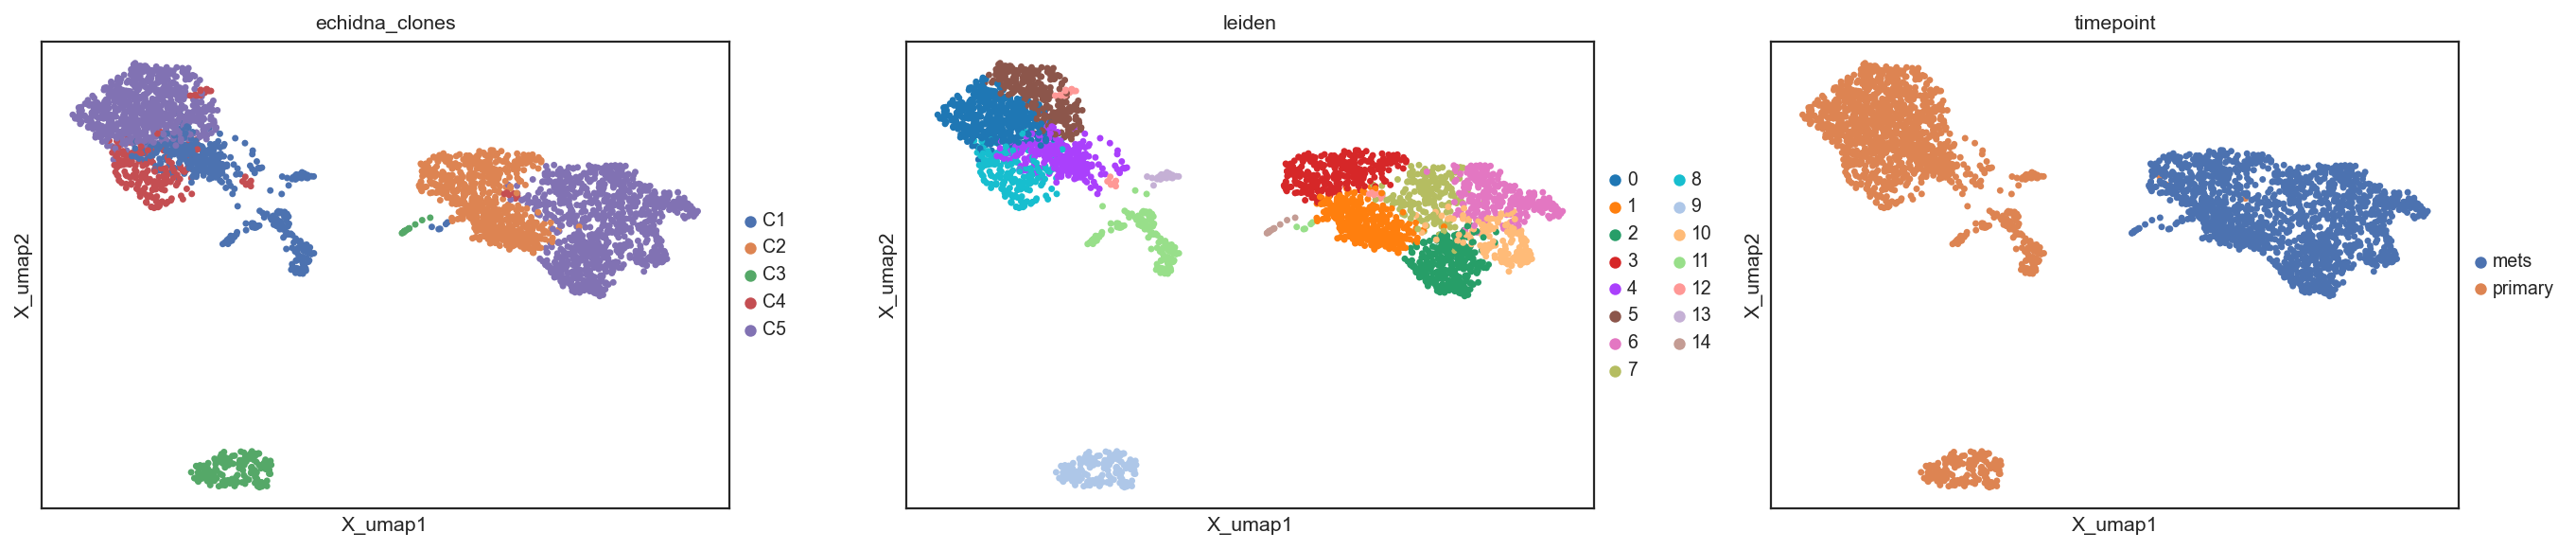

In [23]:
adata.obs["leiden"] = pd.Categorical(adata.obs["leiden"])
ec.pl.echidna(adata, ["echidna_clones", "leiden","timepoint"])

2025-07-12 21:26:28,186 | INFO : maxp pruned
2025-07-12 21:26:28,186 | INFO : LTSH dropped
2025-07-12 21:26:28,187 | INFO : cmap pruned
2025-07-12 21:26:28,187 | INFO : kern dropped
2025-07-12 21:26:28,189 | INFO : post pruned
2025-07-12 21:26:28,190 | INFO : PCLT dropped
2025-07-12 21:26:28,190 | INFO : JSTF dropped
2025-07-12 21:26:28,190 | INFO : DSIG dropped
2025-07-12 21:26:28,192 | INFO : GPOS pruned
2025-07-12 21:26:28,193 | INFO : GSUB pruned
2025-07-12 21:26:28,195 | INFO : glyf pruned
2025-07-12 21:26:28,197 | INFO : Added gid0 to subset
2025-07-12 21:26:28,198 | INFO : Added first four glyphs to subset
2025-07-12 21:26:28,198 | INFO : Closing glyph list over 'GSUB': 23 glyphs before
2025-07-12 21:26:28,198 | INFO : Glyph names: ['.notdef', '.null', 'A', 'M', 'P', 'U', 'd', 'e', 'eight', 'five', 'four', 'i', 'l', 'n', 'nine', 'nonmarkingreturn', 'one', 'seven', 'six', 'space', 'three', 'two', 'zero']
2025-07-12 21:26:28,199 | INFO : Glyph IDs:   [0, 1, 2, 3, 19, 20, 21, 22, 2

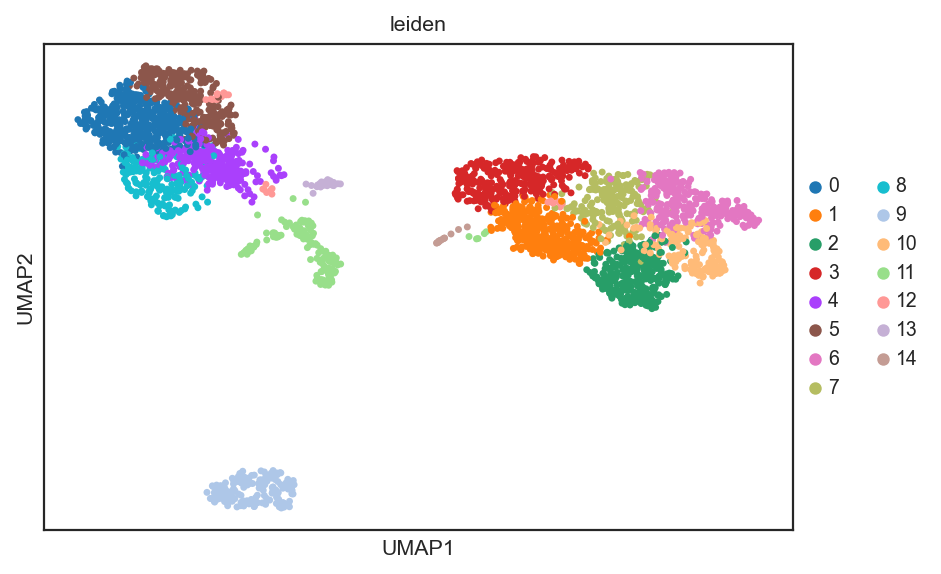

In [174]:
sc.pl.umap(adata, color=["leiden"], save='leiden.pdf')

2025-07-12 21:26:10,971 | INFO : maxp pruned
2025-07-12 21:26:10,971 | INFO : LTSH dropped
2025-07-12 21:26:10,972 | INFO : cmap pruned
2025-07-12 21:26:10,972 | INFO : kern dropped
2025-07-12 21:26:10,974 | INFO : post pruned
2025-07-12 21:26:10,975 | INFO : PCLT dropped
2025-07-12 21:26:10,975 | INFO : JSTF dropped
2025-07-12 21:26:10,975 | INFO : DSIG dropped
2025-07-12 21:26:10,978 | INFO : GPOS pruned
2025-07-12 21:26:10,980 | INFO : GSUB pruned
2025-07-12 21:26:10,982 | INFO : glyf pruned
2025-07-12 21:26:10,984 | INFO : Added gid0 to subset
2025-07-12 21:26:10,984 | INFO : Added first four glyphs to subset
2025-07-12 21:26:10,985 | INFO : Closing glyph list over 'GSUB': 21 glyphs before
2025-07-12 21:26:10,985 | INFO : Glyph names: ['.notdef', '.null', 'A', 'M', 'P', 'U', 'a', 'e', 'i', 'm', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'r', 's', 'space', 't', 'two', 'y']
2025-07-12 21:26:10,985 | INFO : Glyph IDs:   [0, 1, 2, 3, 20, 21, 36, 48, 51, 56, 68, 72, 76, 80, 81, 82, 83, 8

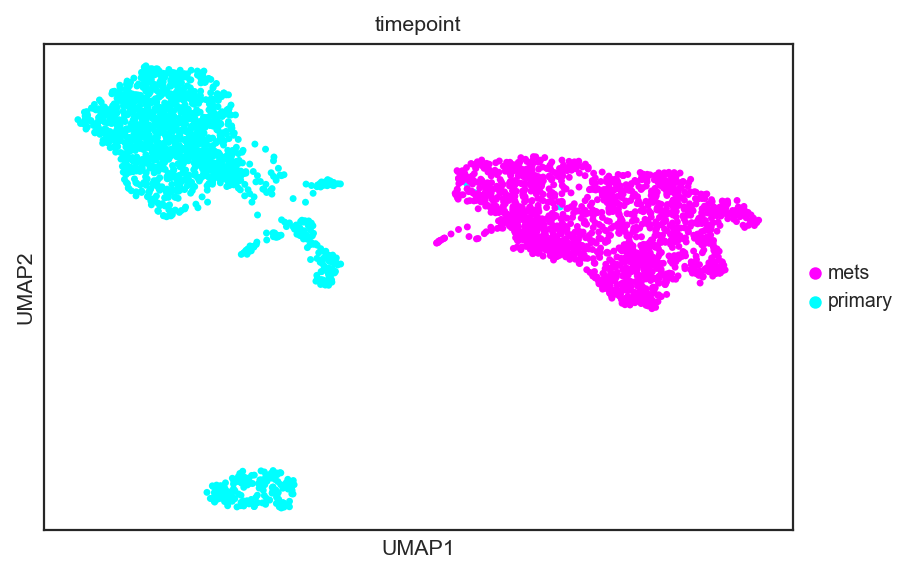

In [173]:
sc.pl.umap(adata, color='timepoint', palette={"mets":"fuchsia", "primary":"aqua"}, save='timepoint.pdf')

In [26]:
met_inds = [1,3,6,7,10,14]

In [27]:
adata.X = adata.X.toarray()

2025-07-12 12:21:49,652 | INFO : `genome` not set, defaulting to hg38wgEncodeGencodeCompV46.


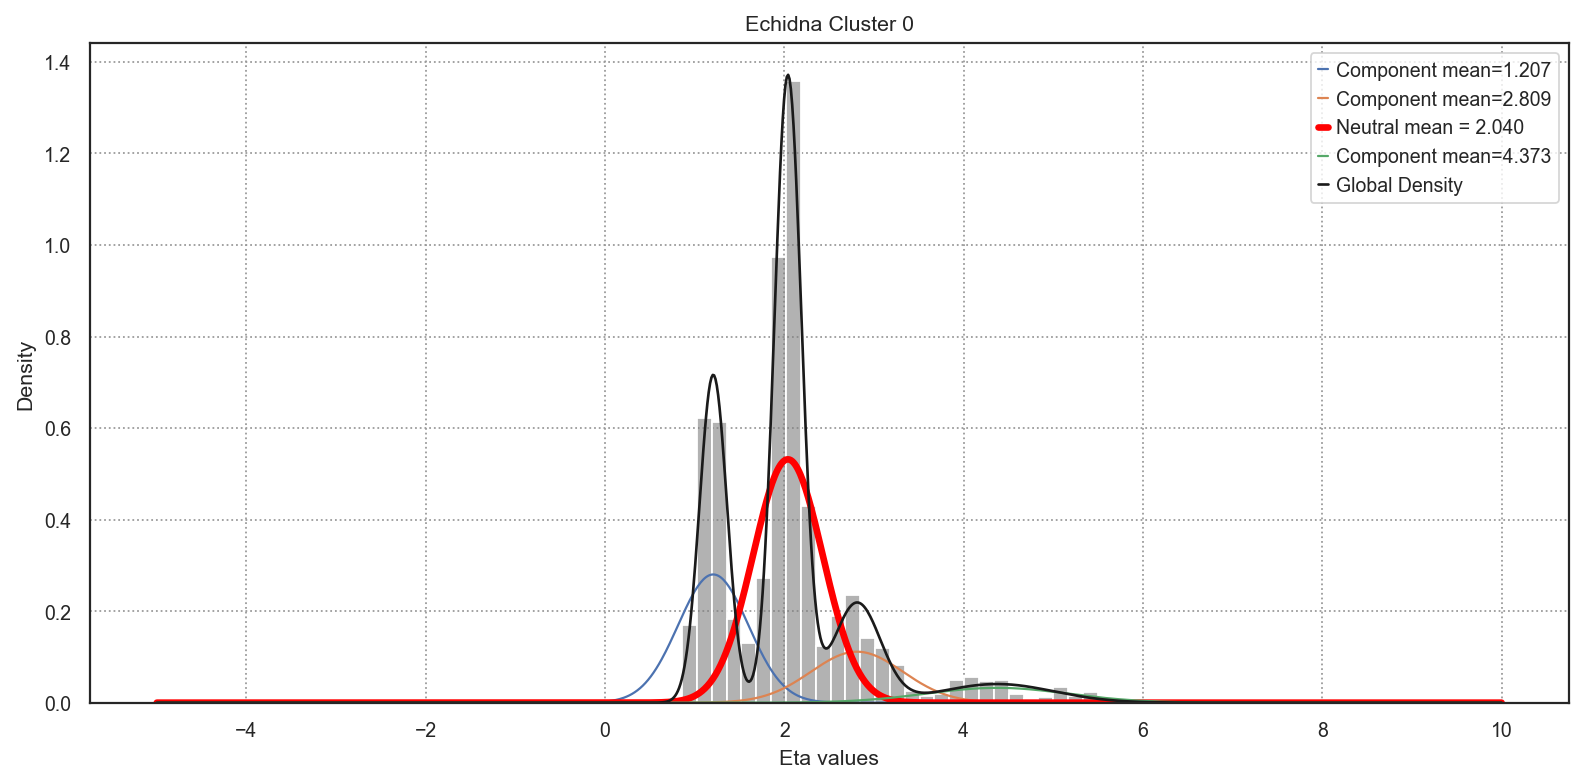

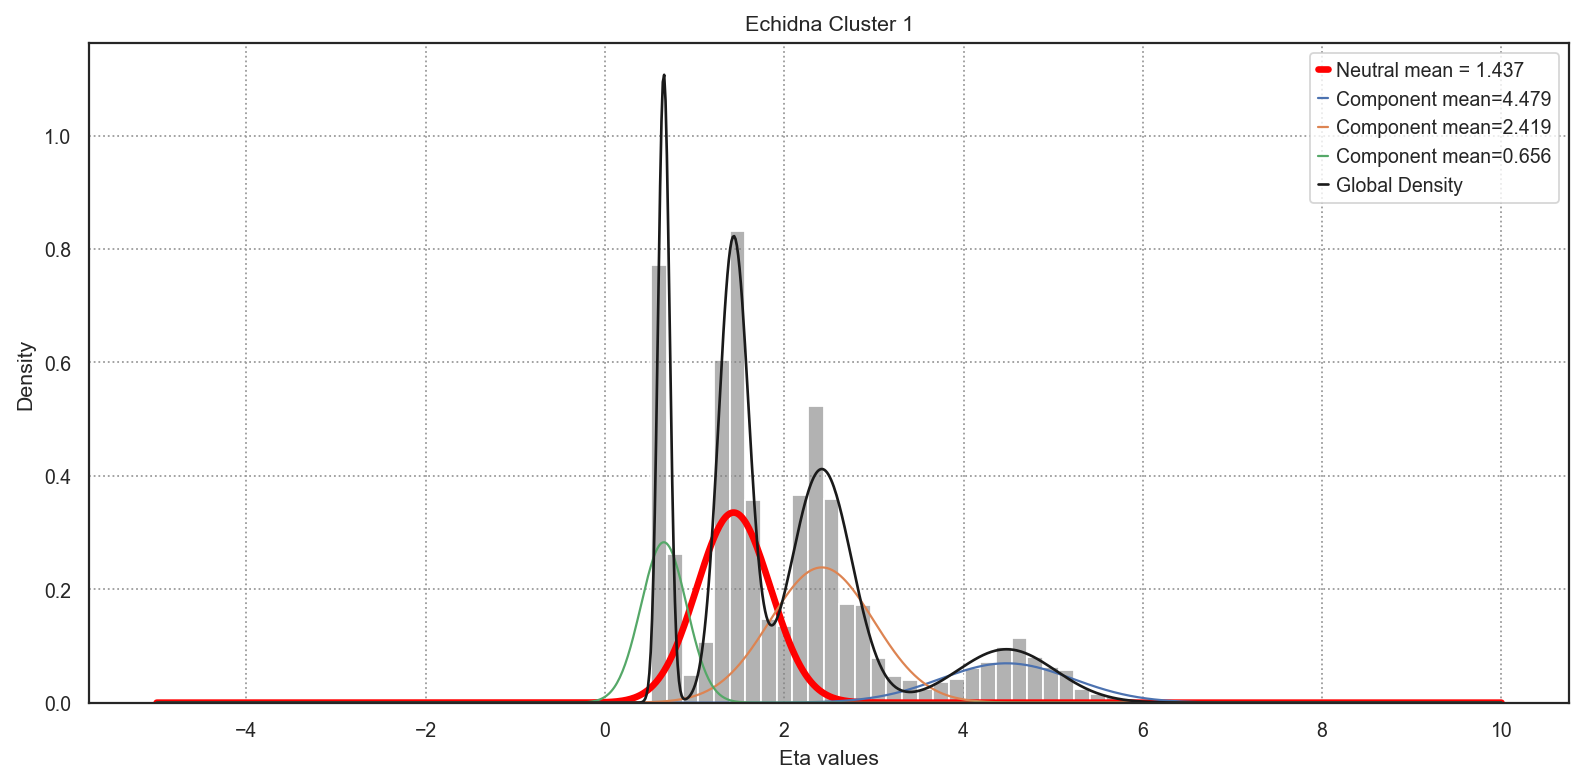

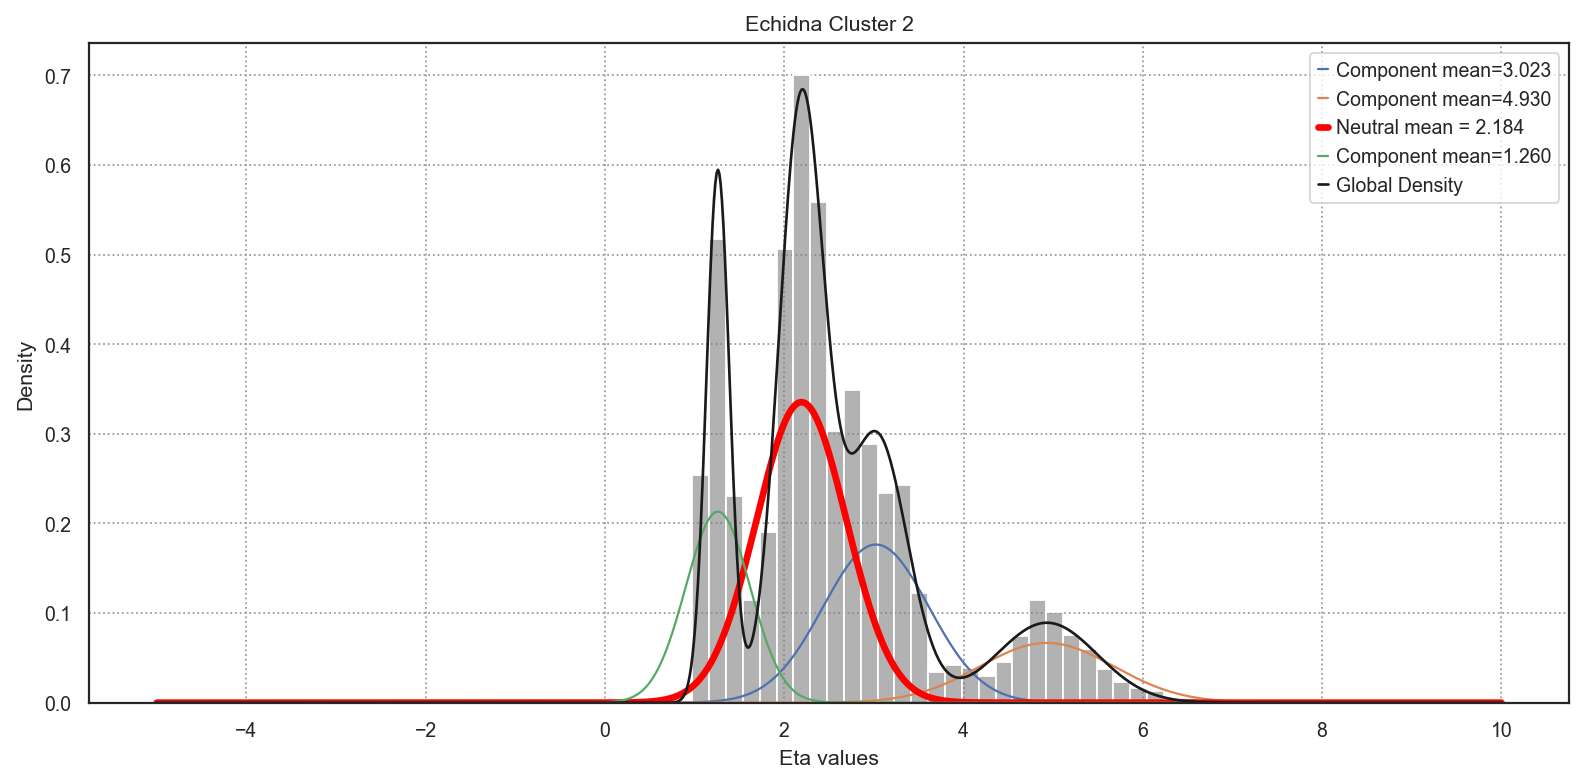

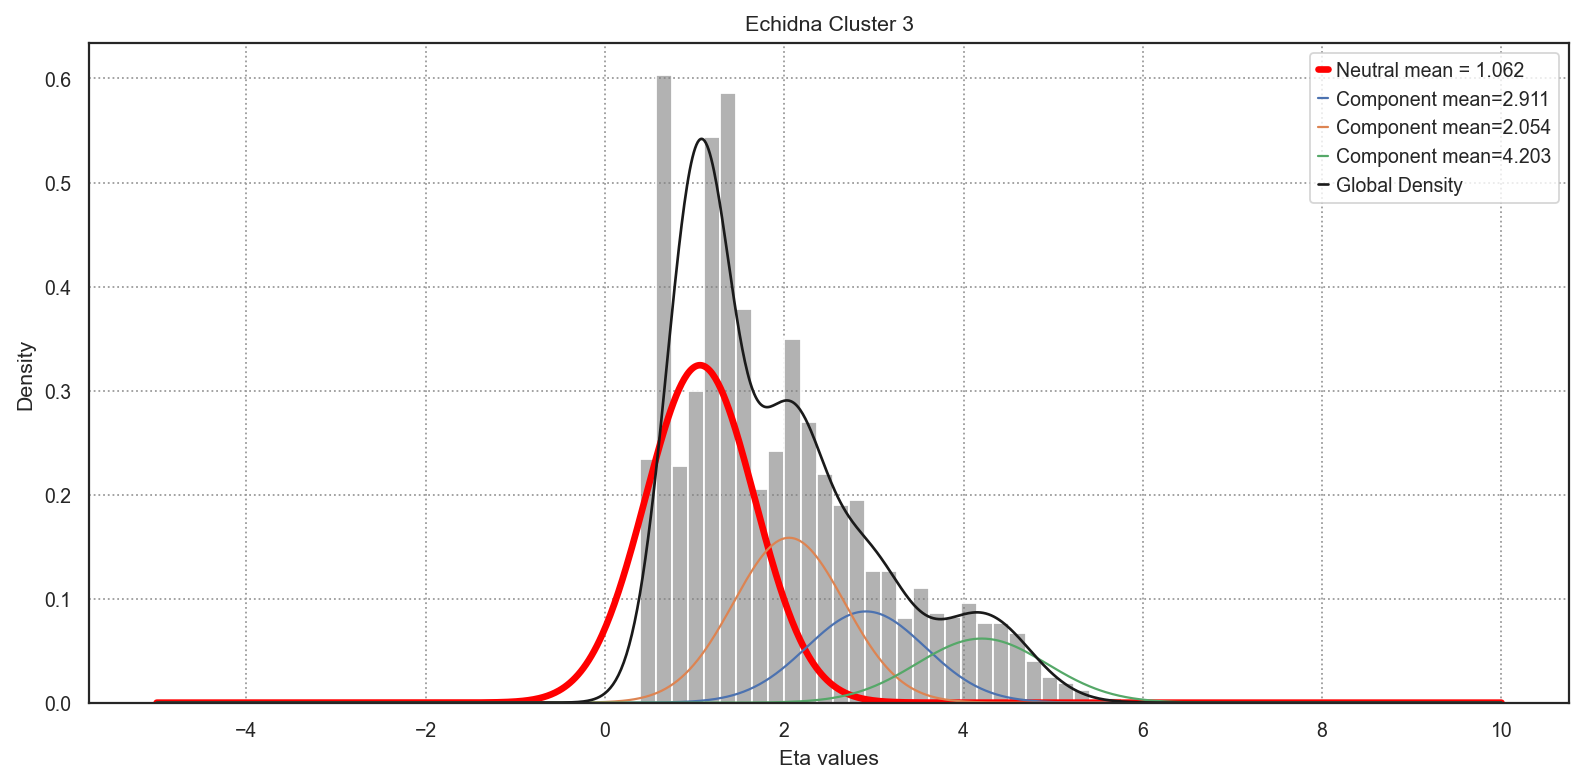

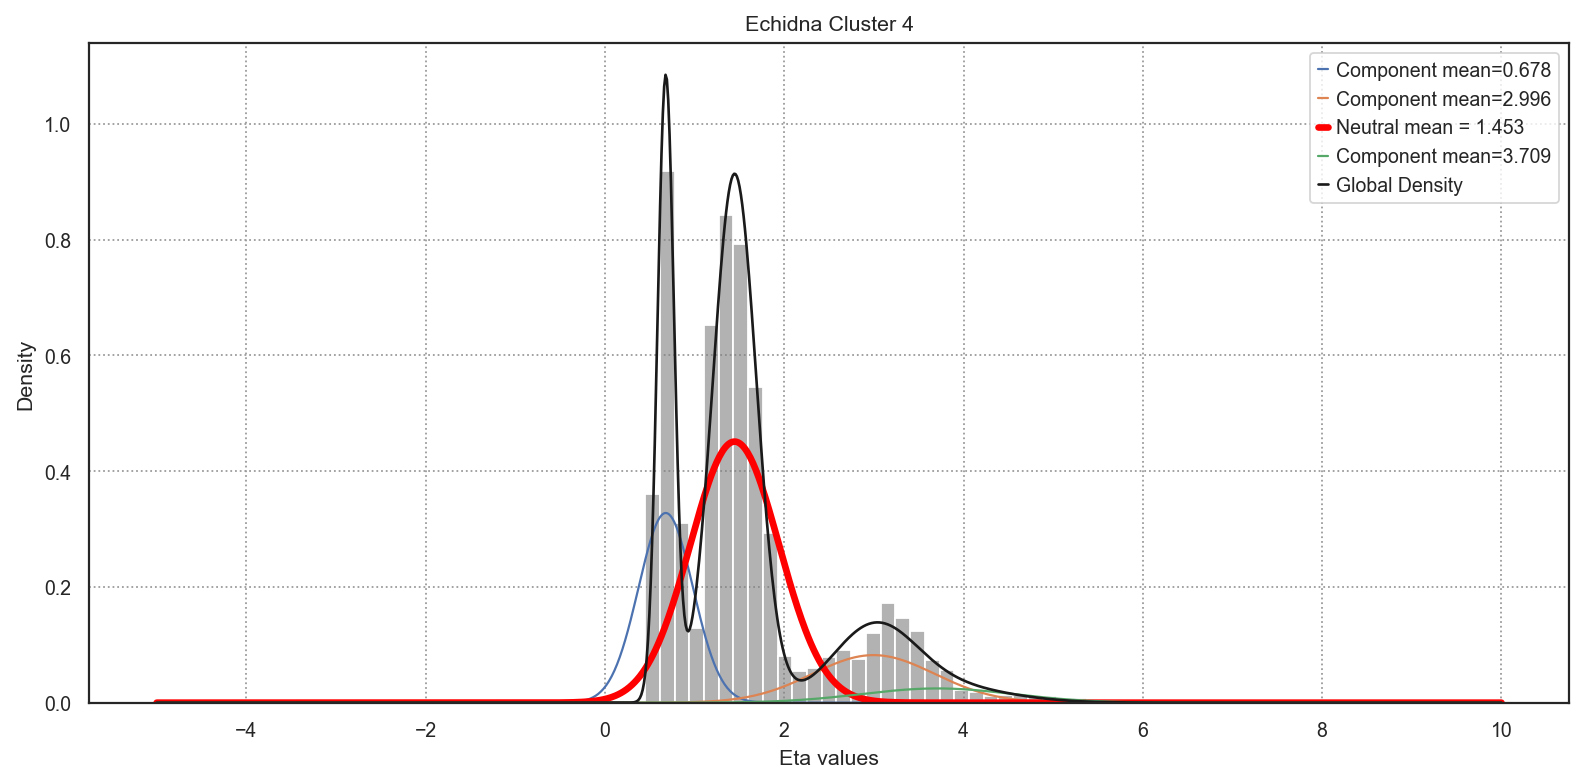

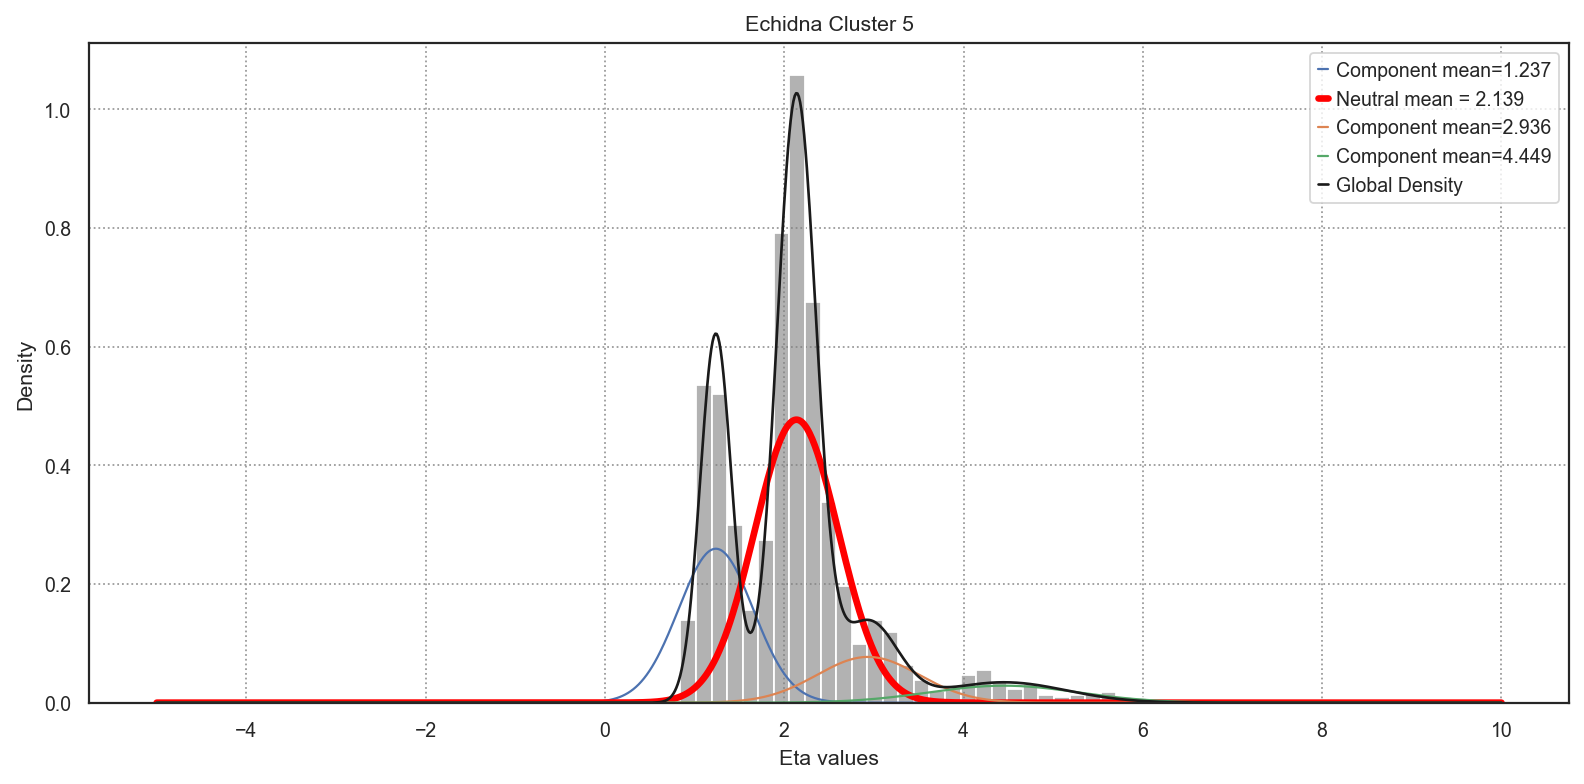

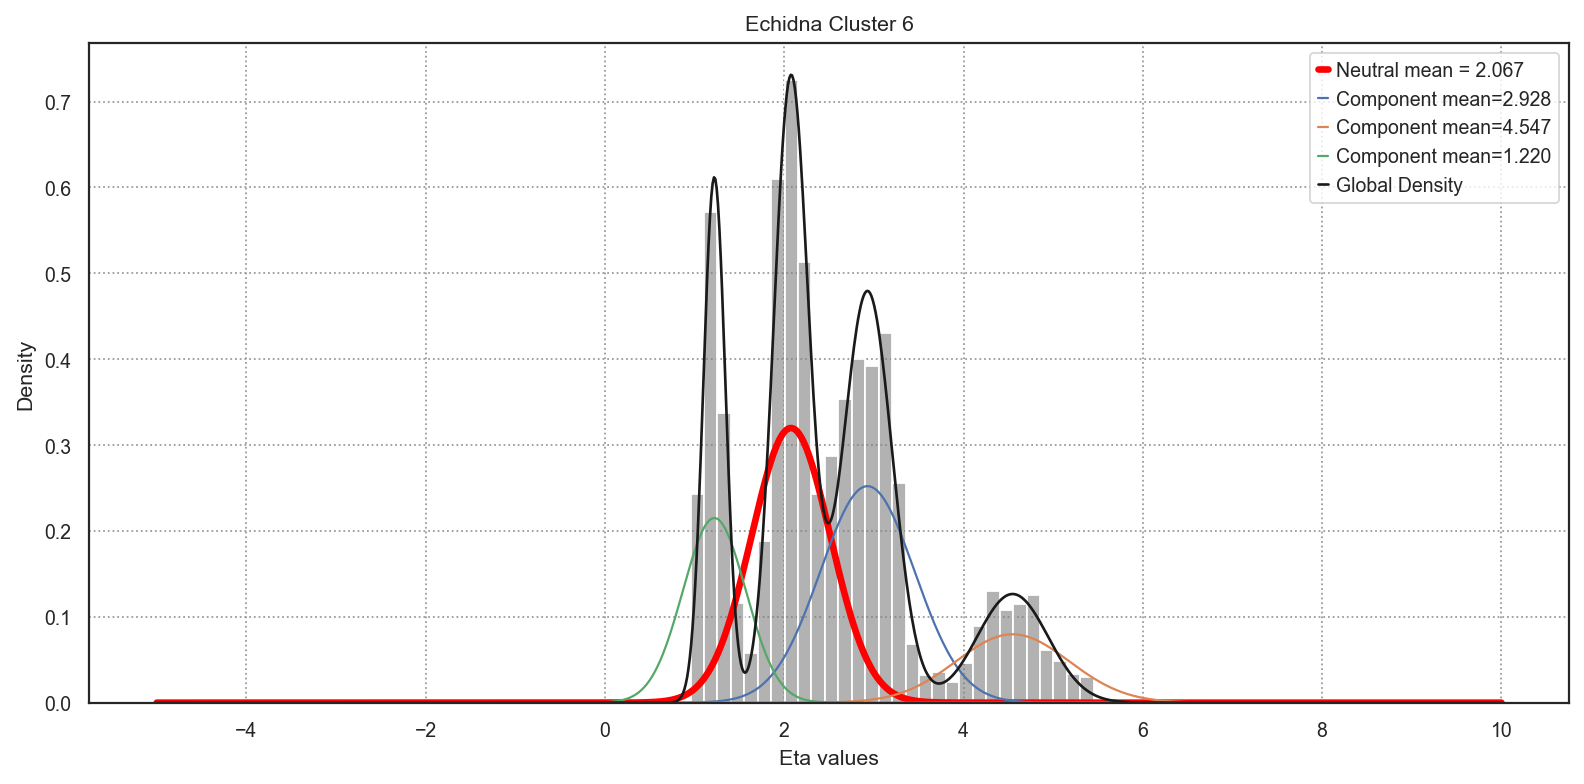

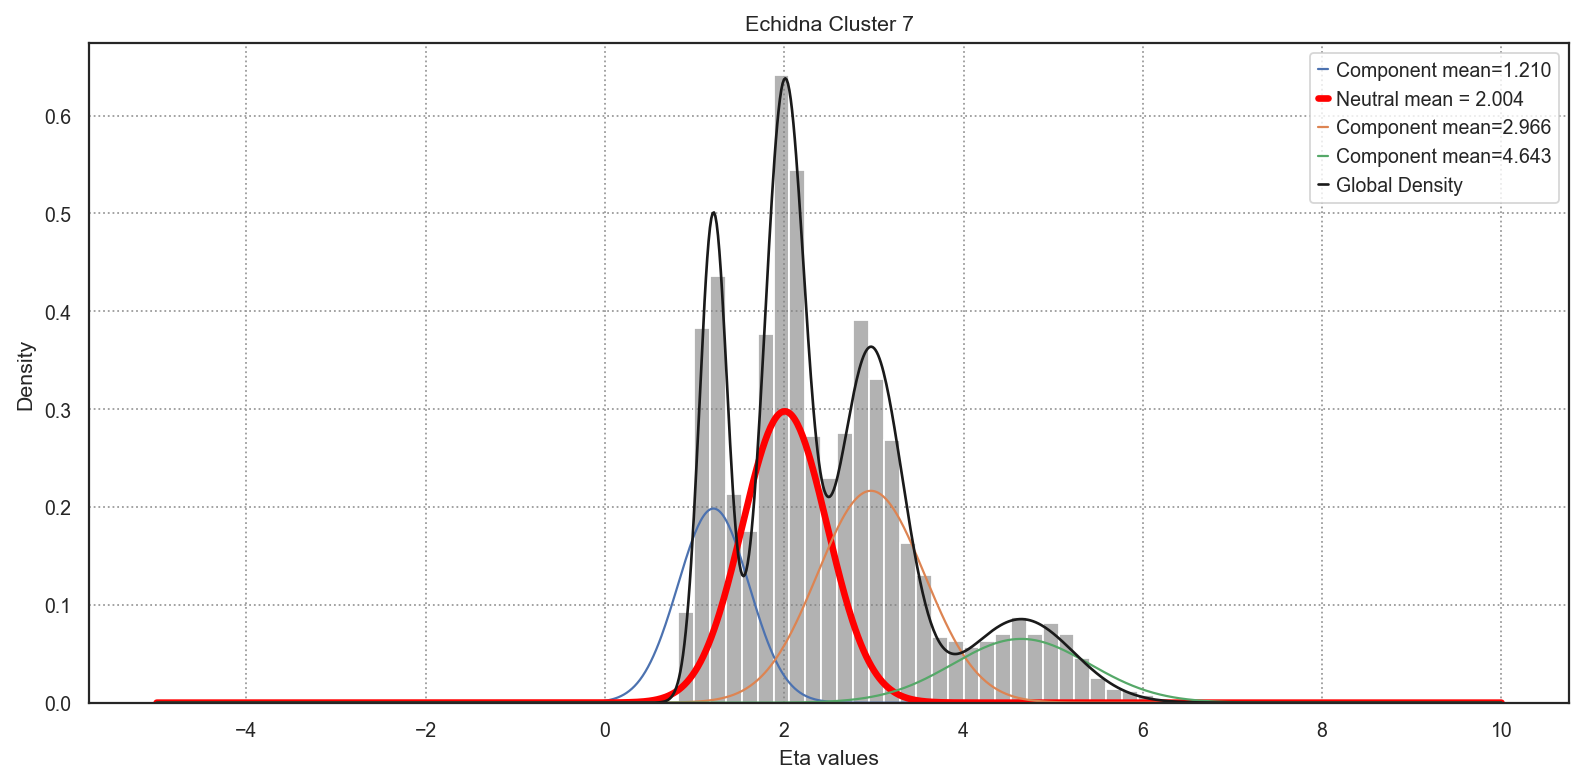

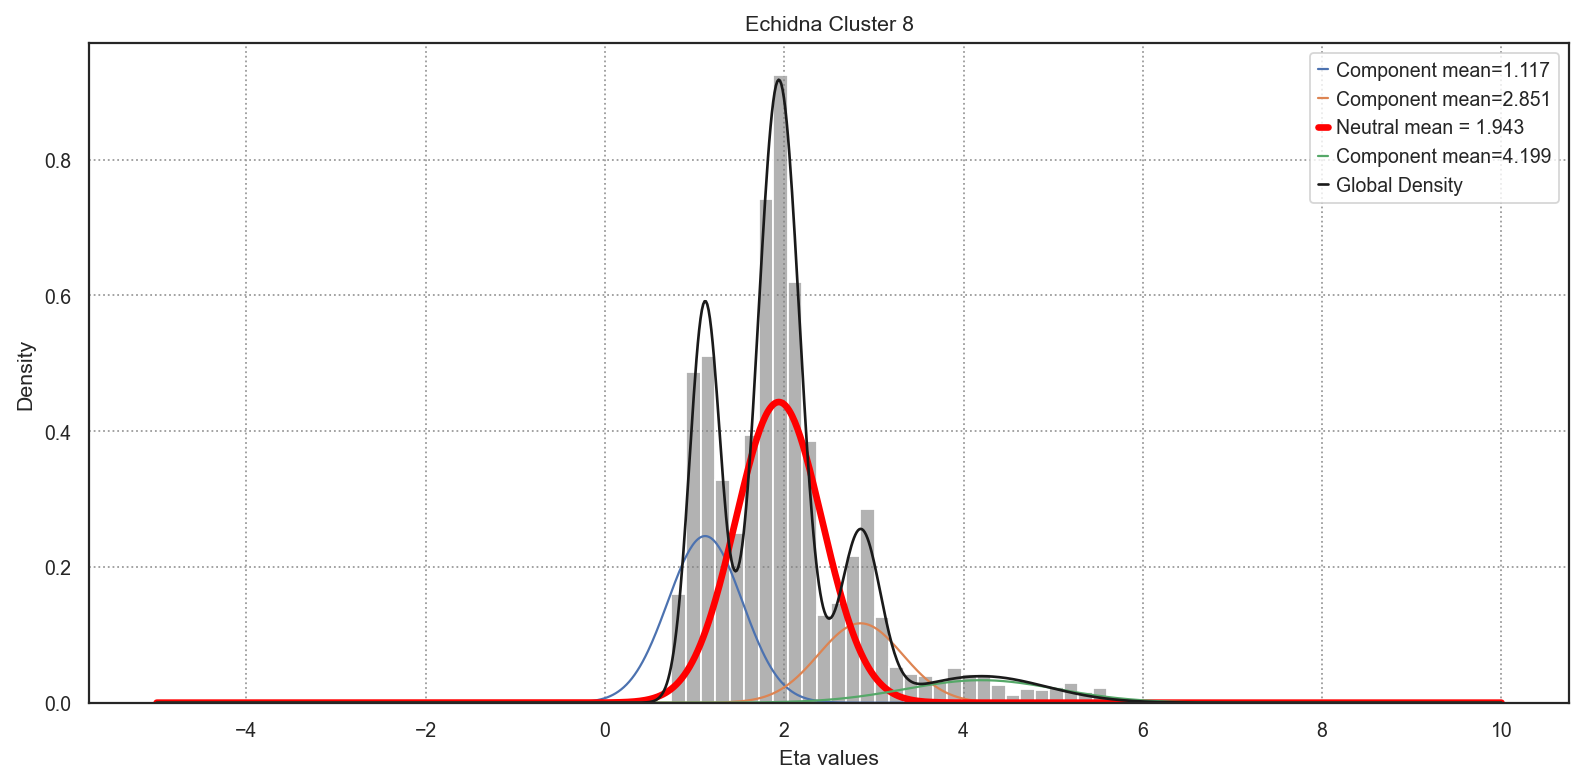

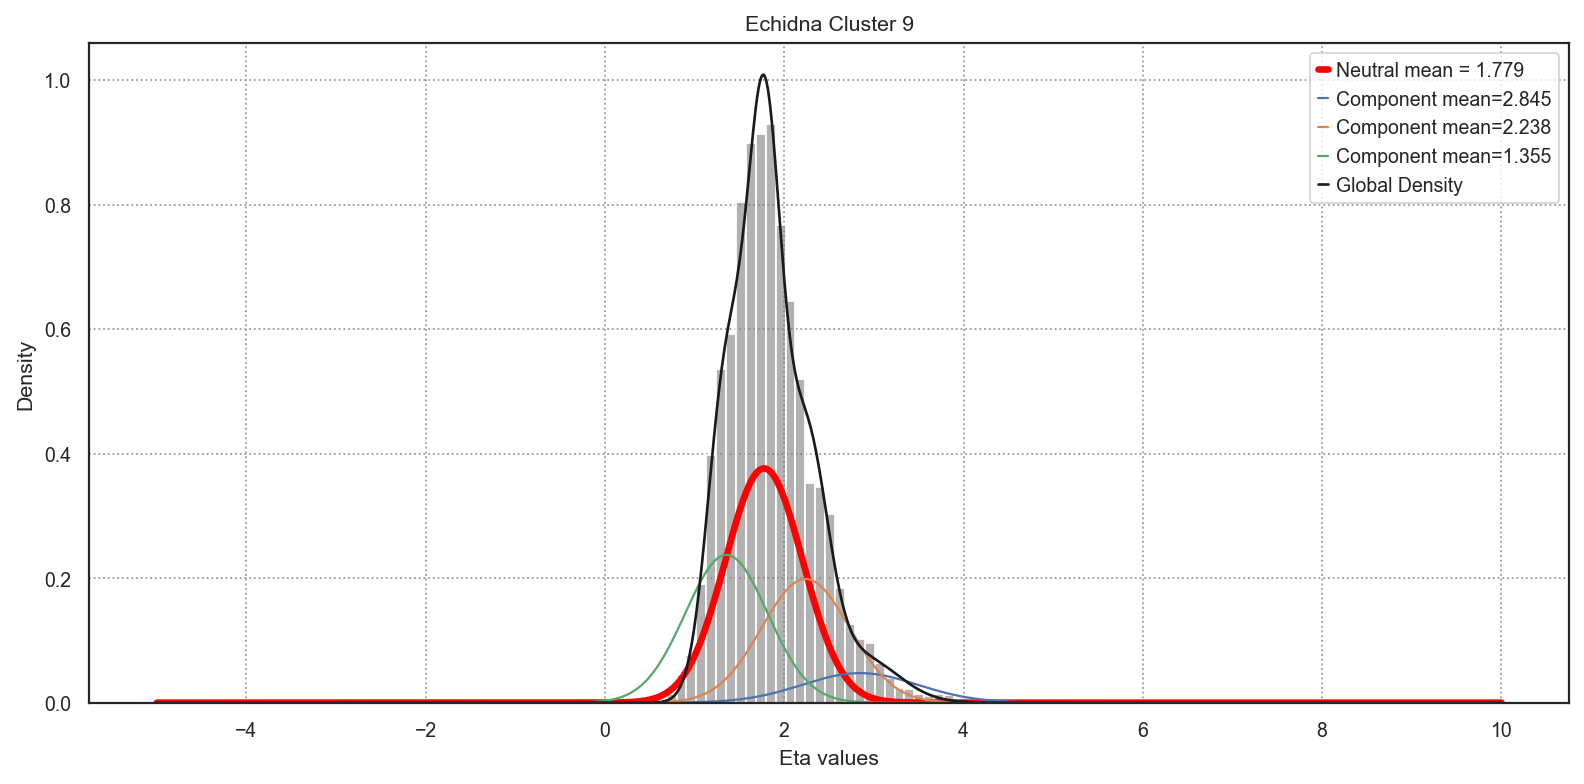

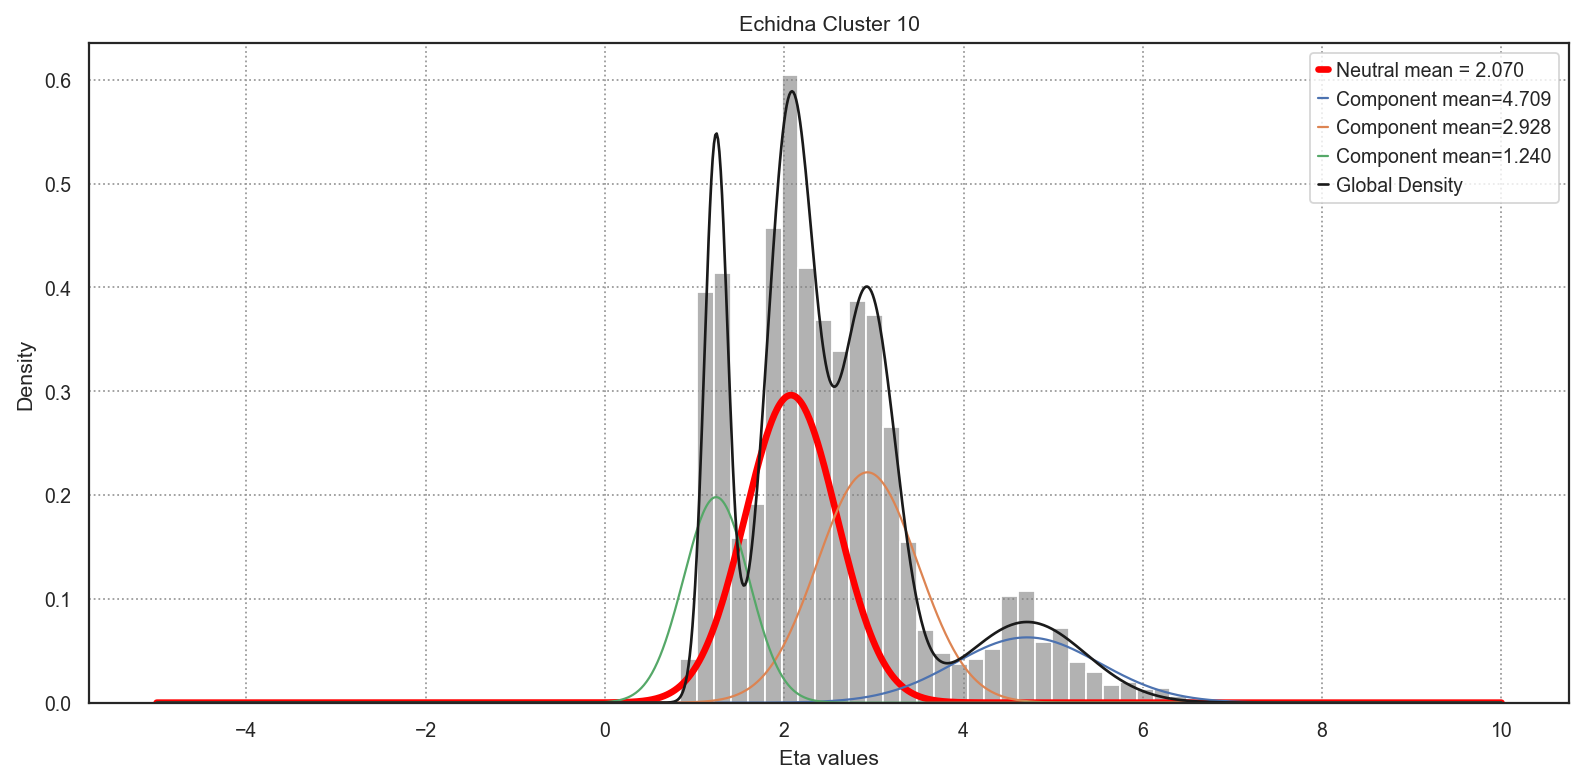

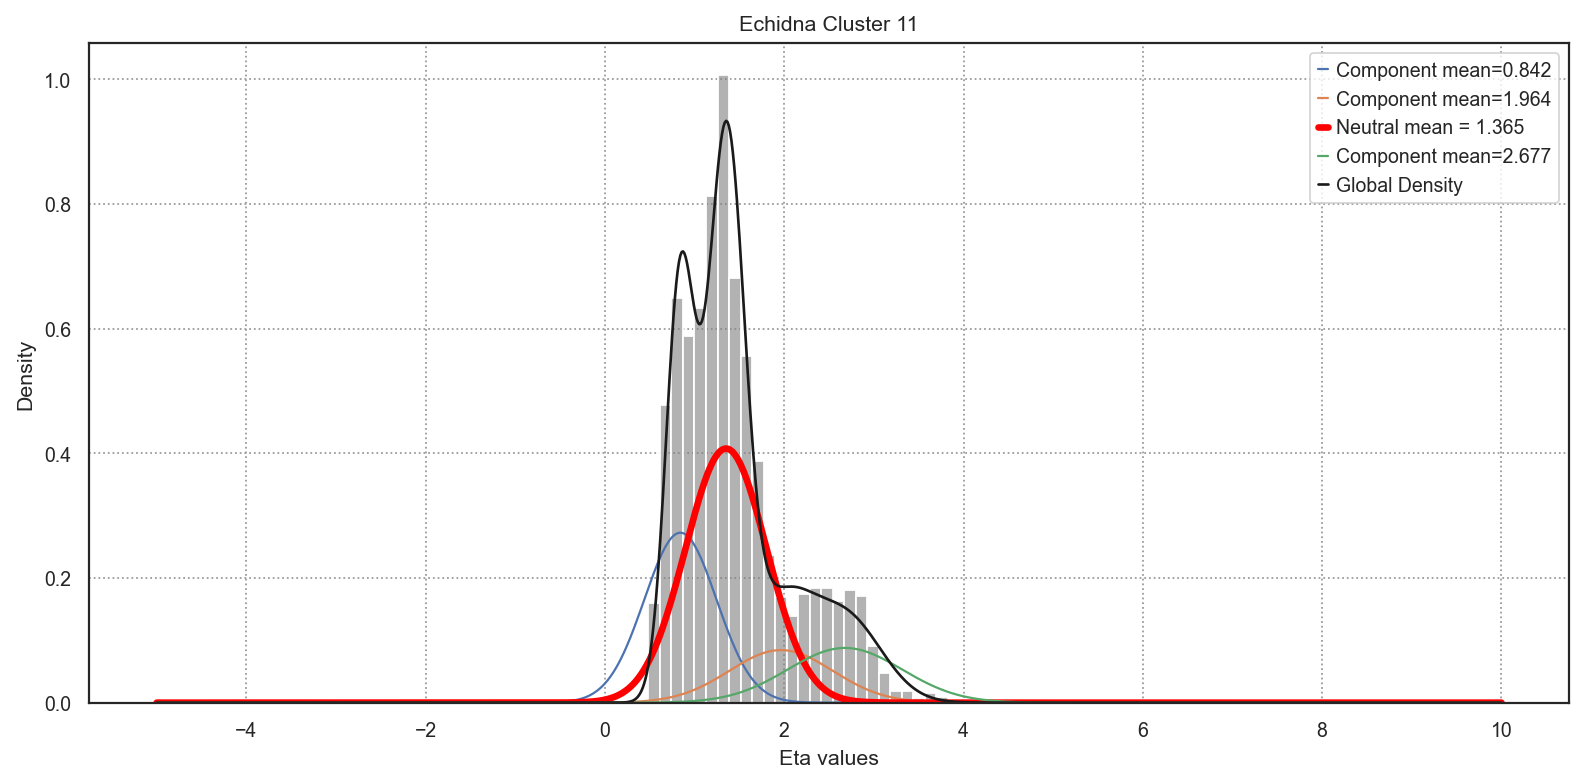

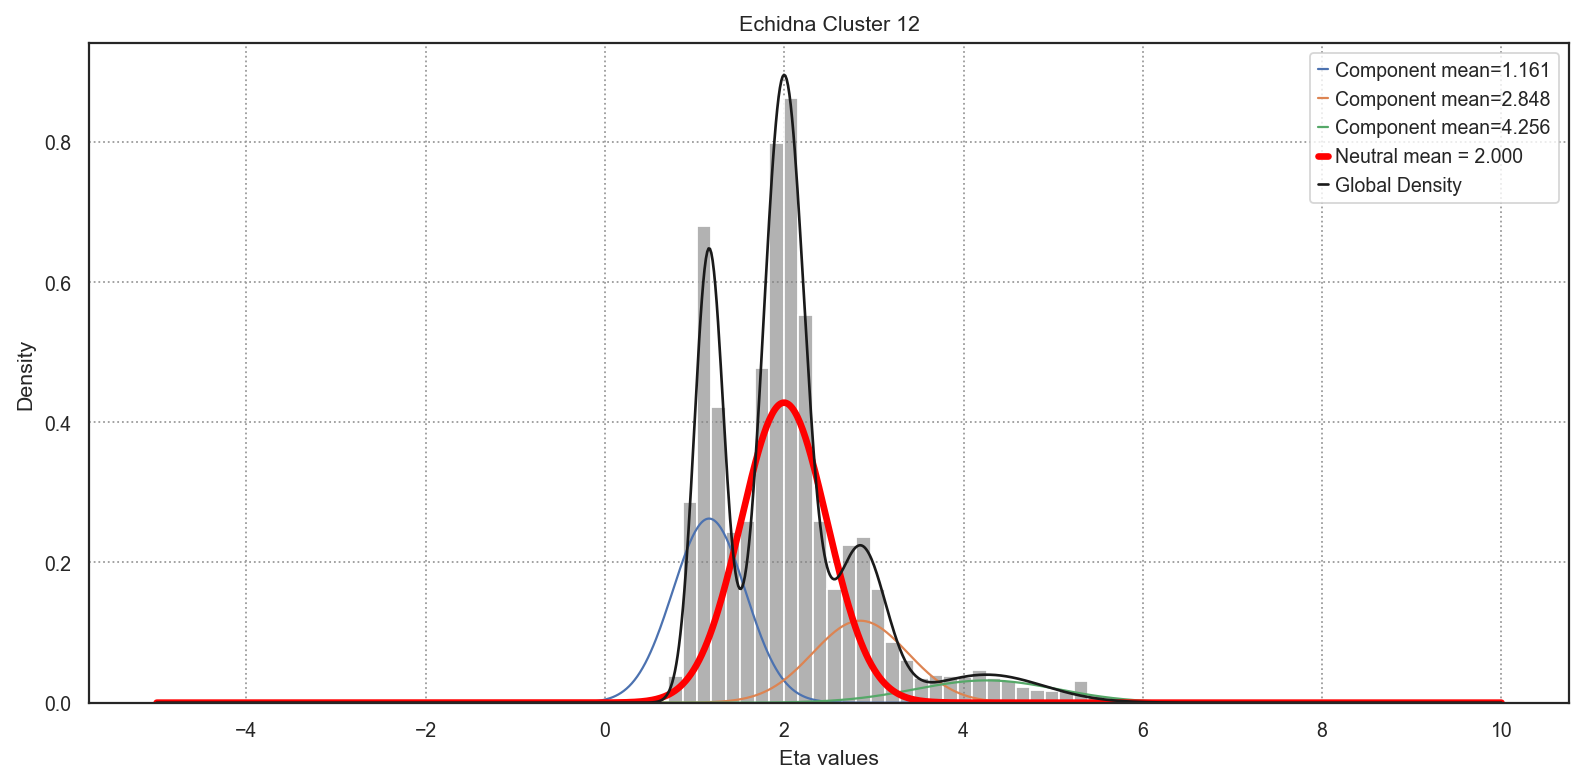

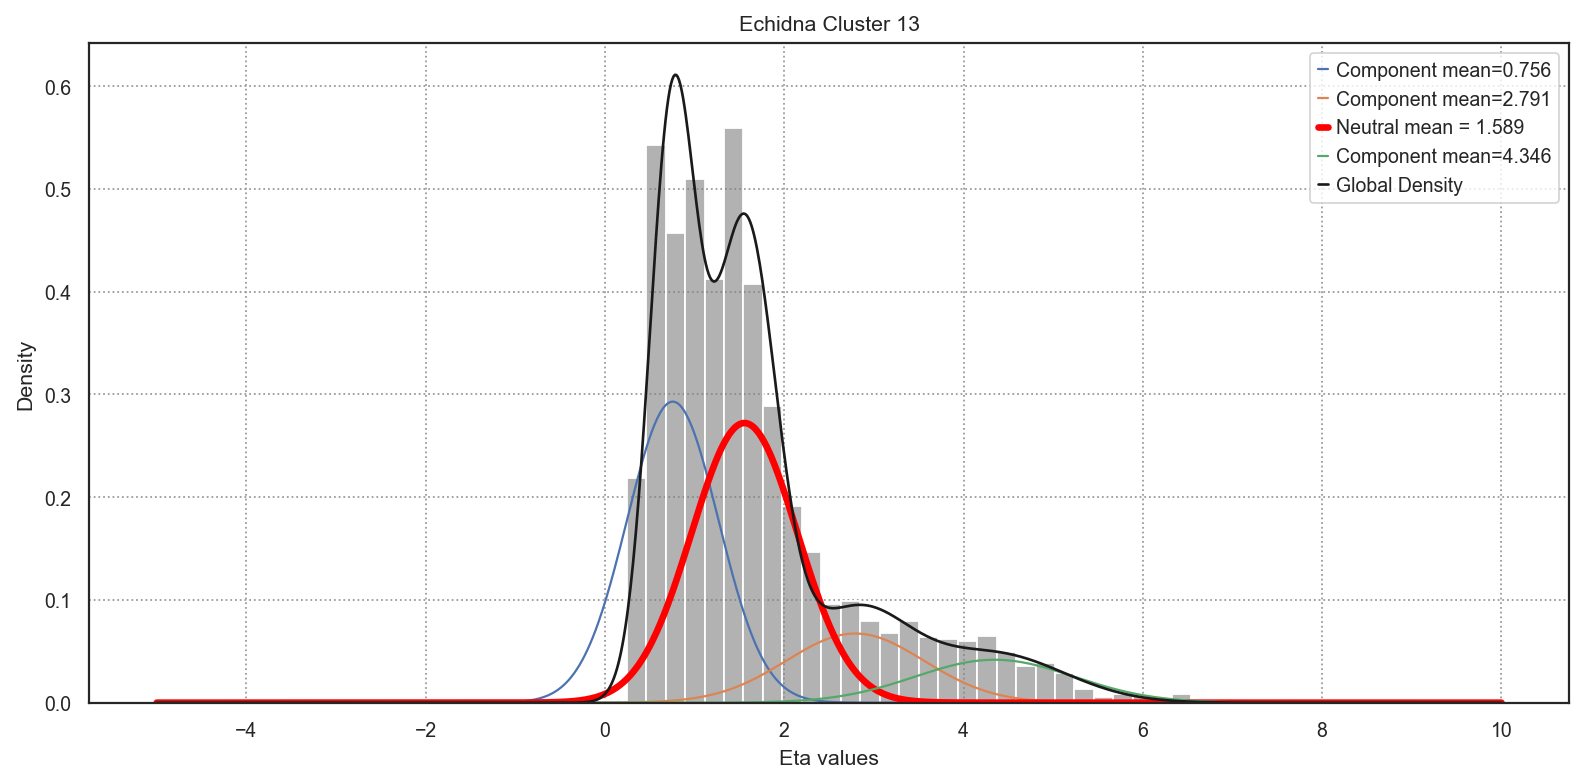

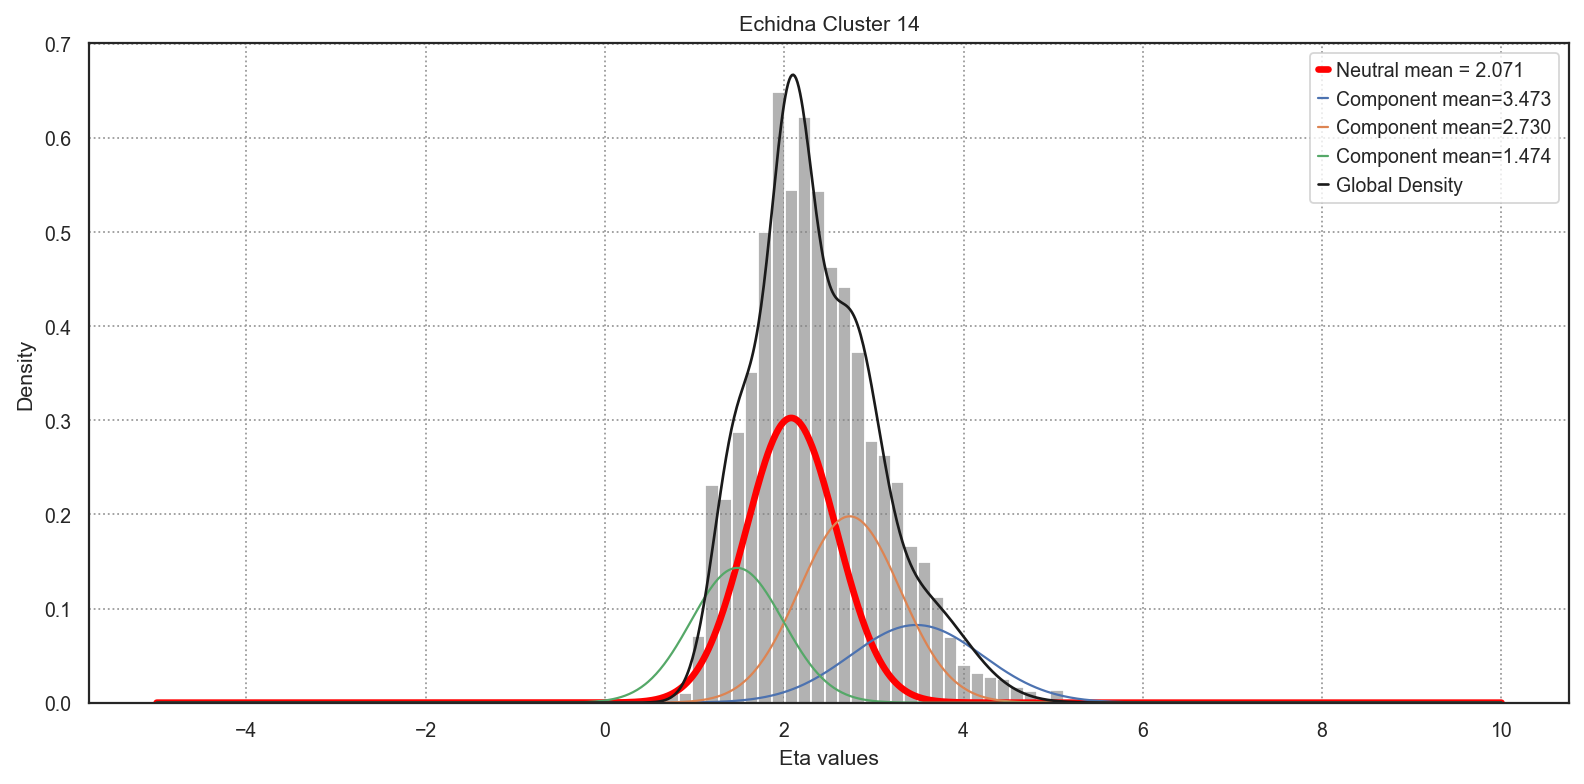

2025-07-12 12:22:51,818 | INFO : Added `.uns['echidna']['save_data']['echi_cnv']` : Path to CNV inference results.
Added `.uns['echidna']['save_data']['gmm_neutrals']` : Path to Echidna cluster neutral value results.


In [28]:
ec.tl.echi_cnv(adata, plot_gmm=True, n_gmm_components=4, neut_method='count_mode')

/Users/joyfan/miniconda3/envs/decipher-env/lib/python3.11/site-packages/echidna/plot/post.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ticks = [(chrom_counts[i-1] + chrom_counts[i])/2 if i != 0 else chrom_counts[i]/2 for i in range(len(chrom_counts))]


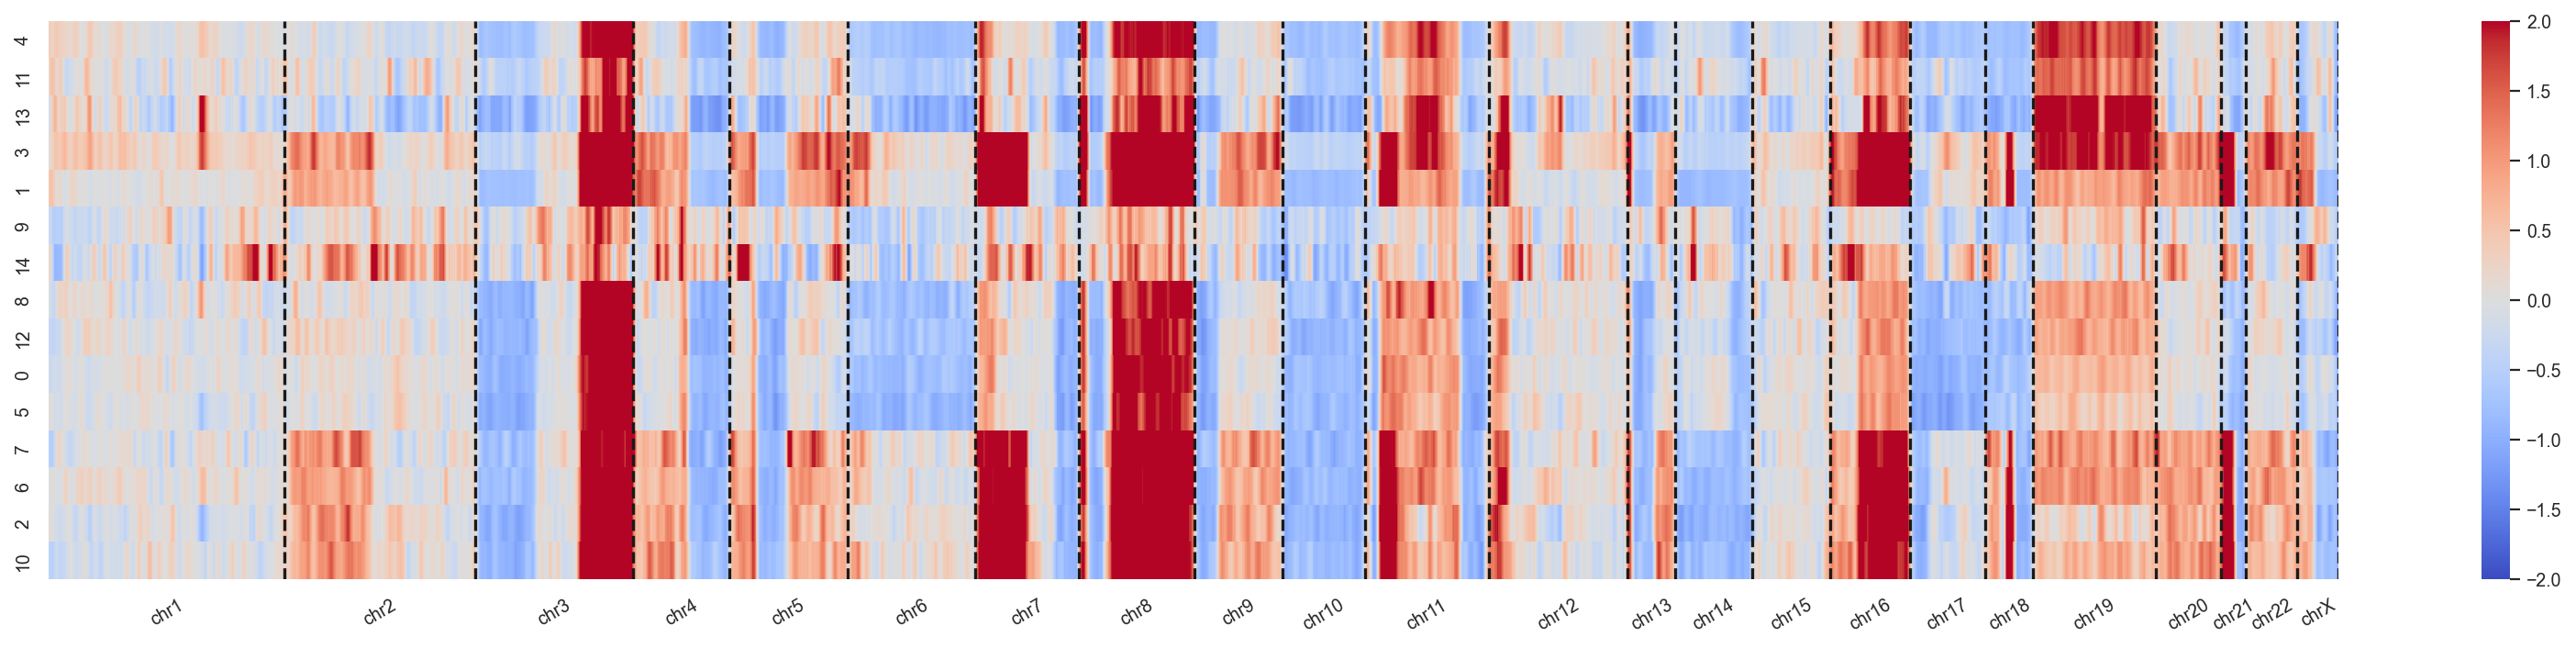

In [29]:
ec.pl.plot_eta(adata)

In [30]:
model = ec.tl.load_model(adata)

eta = pd.DataFrame(model.eta_posterior.detach().numpy())
eta.columns = adata.var_names
eta = eta[[i for i in metw.index if i in eta.columns]]

In [31]:
short_eta = ec.tl.cnv_results(adata).drop("chrom",axis=1)
cnvs = short_eta[[i for i in short_eta.columns if "clone" in i and "states" not in i]]

/Users/joyfan/miniconda3/envs/decipher-env/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


<Figure size 1600x400 with 0 Axes>

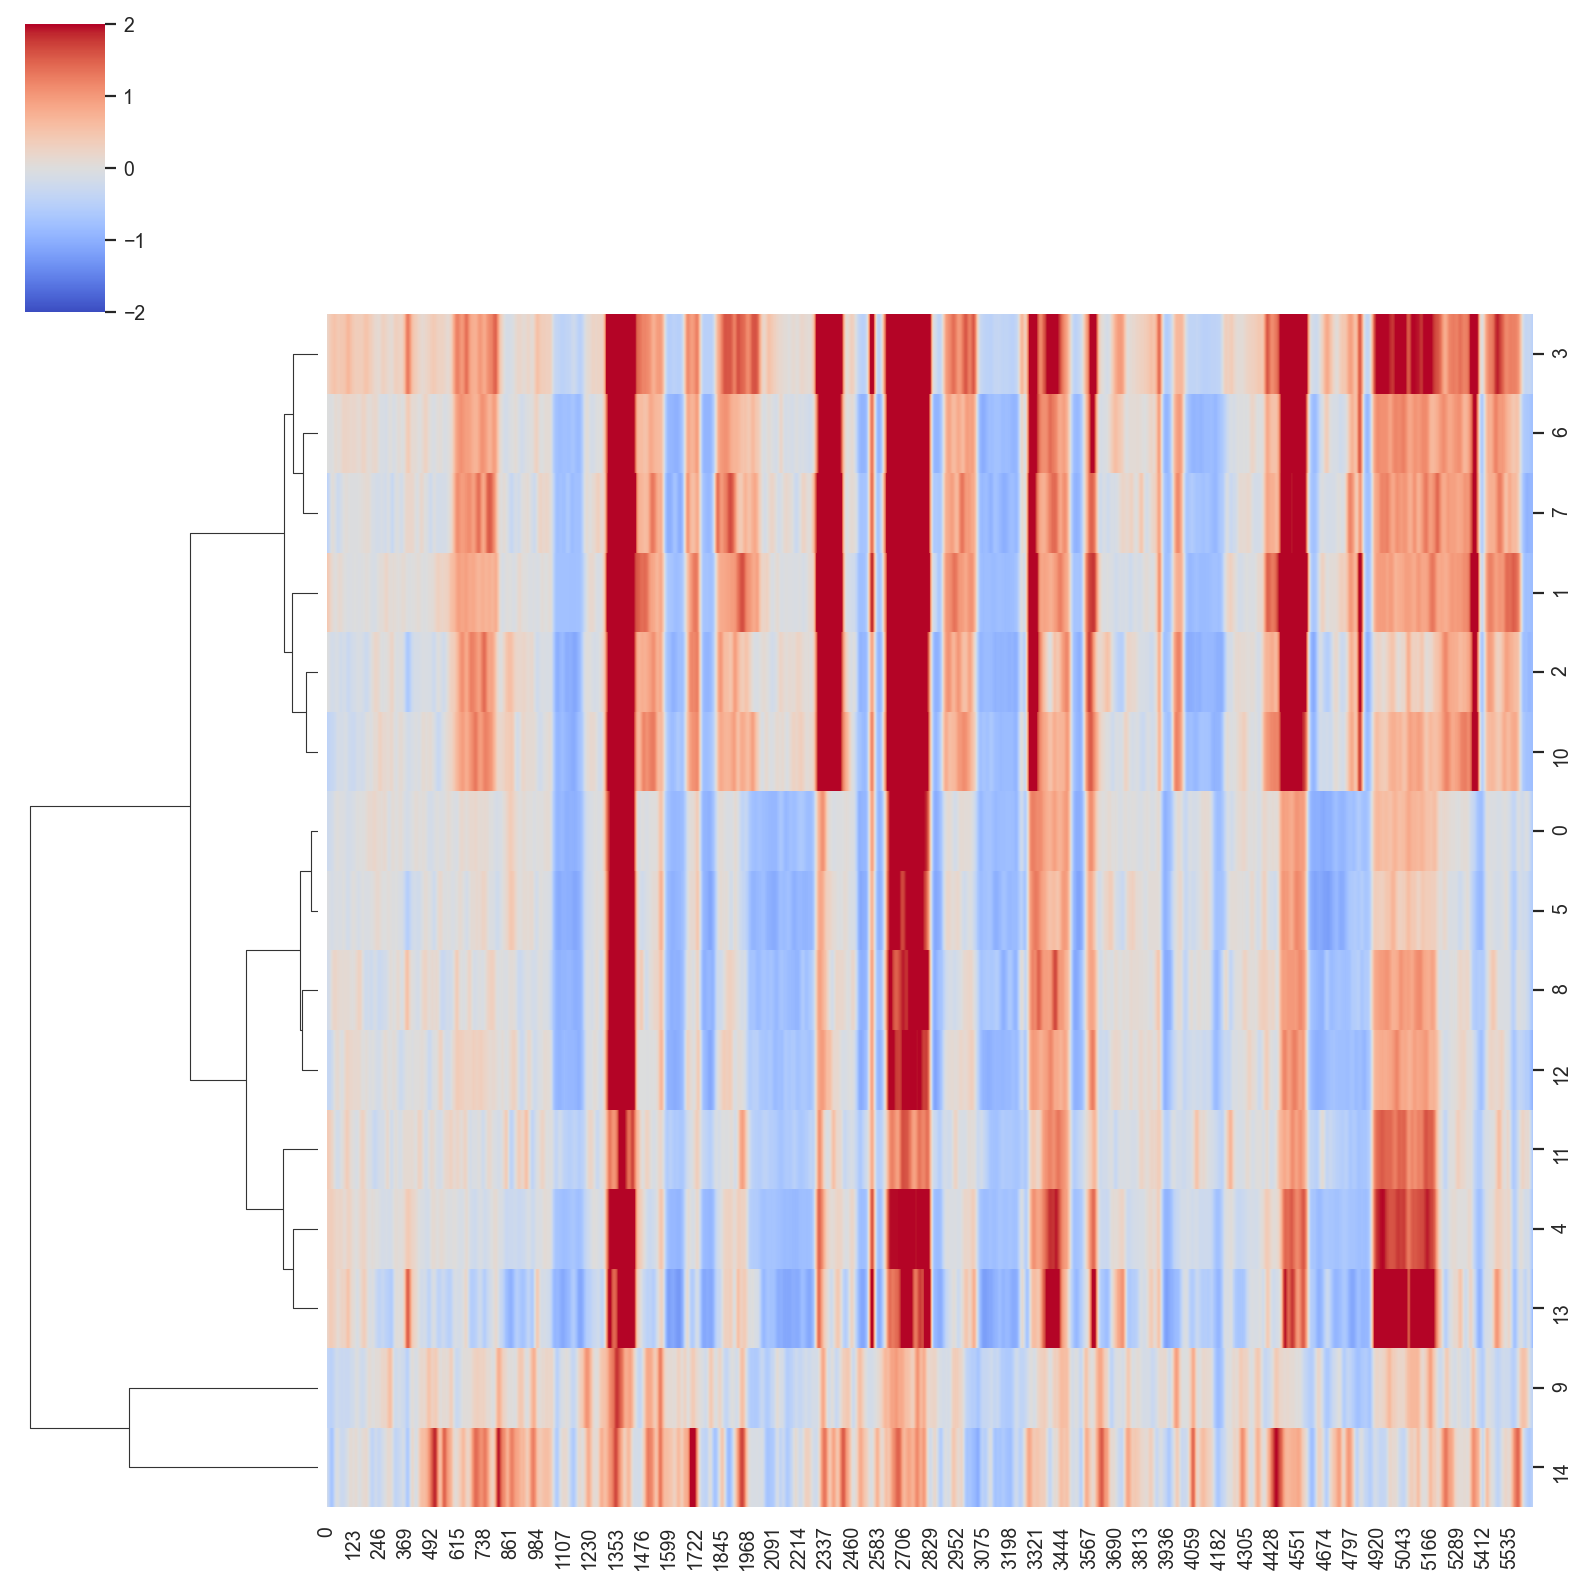

In [32]:
plt.figure(figsize=(20,5))
cl = sns.clustermap(scipy.ndimage.gaussian_filter1d(cnvs.T, sigma=10), cmap='coolwarm', vmin=-2, vmax=2, col_cluster=False, metric='correlation')

In [44]:
# For row clustering
row_linkage = cl.dendrogram_row.linkage

In [92]:
from scipy.cluster.hierarchy import fcluster

# Example threshold (you'll need to choose one based on your dendrogram scale)
threshold = .08

# Cluster by threshold
row_labels = fcluster(row_linkage, threshold, criterion='distance')

In [93]:
adata.obs["echidna_clones_mod"]=[str(row_labels[i]) for i in adata.obs["leiden"]]

2025-07-12 13:16:41,154 | INFO : maxp pruned
2025-07-12 13:16:41,155 | INFO : LTSH dropped
2025-07-12 13:16:41,155 | INFO : cmap pruned
2025-07-12 13:16:41,155 | INFO : kern dropped
2025-07-12 13:16:41,158 | INFO : post pruned
2025-07-12 13:16:41,158 | INFO : PCLT dropped
2025-07-12 13:16:41,158 | INFO : JSTF dropped
2025-07-12 13:16:41,159 | INFO : DSIG dropped
2025-07-12 13:16:41,161 | INFO : GPOS pruned
2025-07-12 13:16:41,162 | INFO : GSUB pruned
2025-07-12 13:16:41,164 | INFO : glyf pruned
2025-07-12 13:16:41,166 | INFO : Added gid0 to subset
2025-07-12 13:16:41,167 | INFO : Added first four glyphs to subset
2025-07-12 13:16:41,167 | INFO : Closing glyph list over 'GSUB': 25 glyphs before
2025-07-12 13:16:41,167 | INFO : Glyph names: ['.notdef', '.null', 'A', 'M', 'P', 'U', 'a', 'c', 'd', 'e', 'five', 'four', 'h', 'i', 'l', 'm', 'n', 'nonmarkingreturn', 'o', 'one', 's', 'space', 'three', 'two', 'underscore']
2025-07-12 13:16:41,168 | INFO : Glyph IDs:   [0, 1, 2, 3, 20, 21, 22, 23

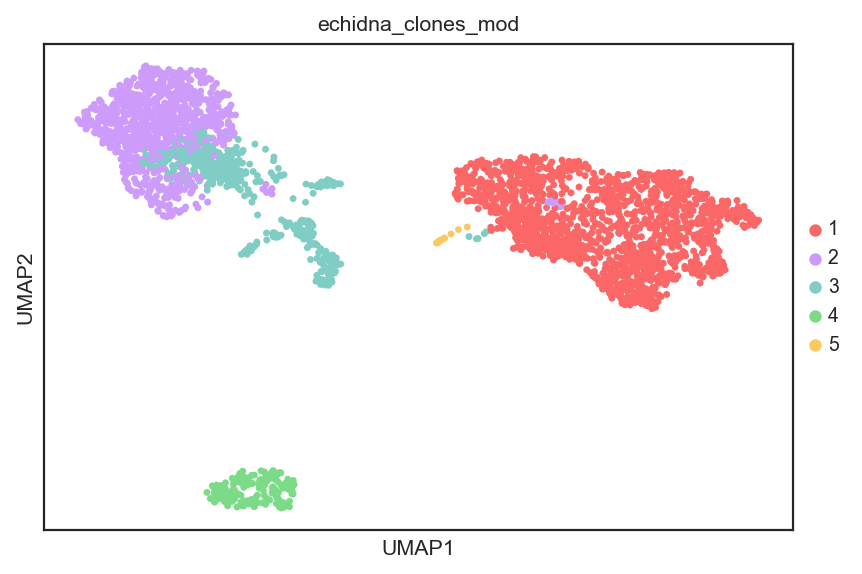

In [100]:
sc.pl.umap(adata, color=["echidna_clones_mod"], palette={
    '1': '#fb6767',
    '2': '#cd9bfa',
    '3': '#7fcdc4',
    '4': '#7bdb87',
    '5': '#fbc964',
    '6': '#fa93d3'
}, save='mets_clones_umap.pdf')

In [95]:
inds = cnvs.columns[cl.dendrogram_row.reordered_ind]

In [60]:
sc.tl.rank_genes_groups(adata, groupby='timepoint', method='wilcoxon')

In [61]:
mets = sc.get.rank_genes_groups_df(adata, group='mets')
mets = mets[mets["pvals_adj"]<.05]
mets = mets[mets["logfoldchanges"]>0]

In [62]:
genes = mets["names"]

In [63]:
ordered_genes = np.load("ordered_genes.npy")
ordchrs = np.load("ordered_chrs.npy")
pal = {"del":"blue","neut":"grey","amp":"red"}

def eta_no_bin(eta):
    inds = []
    draw_lines = []
    ch = 'chr1'
    chr_list = [ch]
    count=0
    for i in range(len(ordered_genes)):
        if ordered_genes[i] in eta.index:
            inds.append(ordered_genes[i])
            count+=1
            if ordchrs[i]!=ch:
                draw_lines.append(count)
                ch=ordchrs[i]
                chr_list.append(ch)
    draw_lines.append(count)
    return draw_lines, chr_list, inds

In [96]:
metas_dict = pd.DataFrame()
obs = adata.obs
for cl in np.unique(adata.obs["leiden"]):
    sampl = pd.DataFrame(np.unique(obs[obs['leiden']==cl]["timepoint"], return_counts=True)).T.sort_values(by=1, ascending=False).iloc[0][0]
    metas_dict[cl] = [sampl]

In [97]:
# Example metadata
clone = pd.Series(row_labels, index=cnvs.columns, name='Clones')
metas = pd.Series(list(metas_dict.T[0]), index=cnvs.columns, name='Metastasis')

# Map to colors
group_colors = clone.map({
    1: '#fb6767',
    2: '#cd9bfa',
    3: '#7fcdc4',
    4: '#7bdb87',
    5: '#fbc964',
    6: '#fa93d3'
})
batch_colors = metas.map({"mets":"fuchsia", "primary":"aqua"})

# Combine into a DataFrame
row_colors = pd.concat([group_colors, batch_colors], axis=1)


/Users/joyfan/miniconda3/envs/decipher-env/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
2025-07-12 13:17:14,126 | INFO : maxp pruned
2025-07-12 13:17:14,126 | INFO : LTSH dropped
2025-07-12 13:17:14,127 | INFO : cmap pruned
2025-07-12 13:17:14,127 | INFO : kern dropped
2025-07-12 13:17:14,129 | INFO : post pruned
2025-07-12 13:17:14,130 | INFO : PCLT dropped
2025-07-12 13:17:14,130 | INFO : JSTF dropped
2025-07-12 13:17:14,130 | INFO : DSIG dropped
2025-07-12 13:17:14,132 | INFO : GPOS pruned
2025-07-12 13:17:14,133 | INFO : GSUB pruned
2025-07-12 13:17:14,135 | INFO : glyf pruned
2025-07-12 13:17:14,137 | INFO : Added gid0 to subset
2025-07-12 13:17:14,138 | INFO : Added first four glyphs to subset
2025-07-12 13:17:14,138 | INFO : Closing glyph list over 'GSUB': 29 glyphs before
2025-07-12 13:17:14,138 | INFO : Glyph names: ['.notdef', '.null', 'C', 'M', '

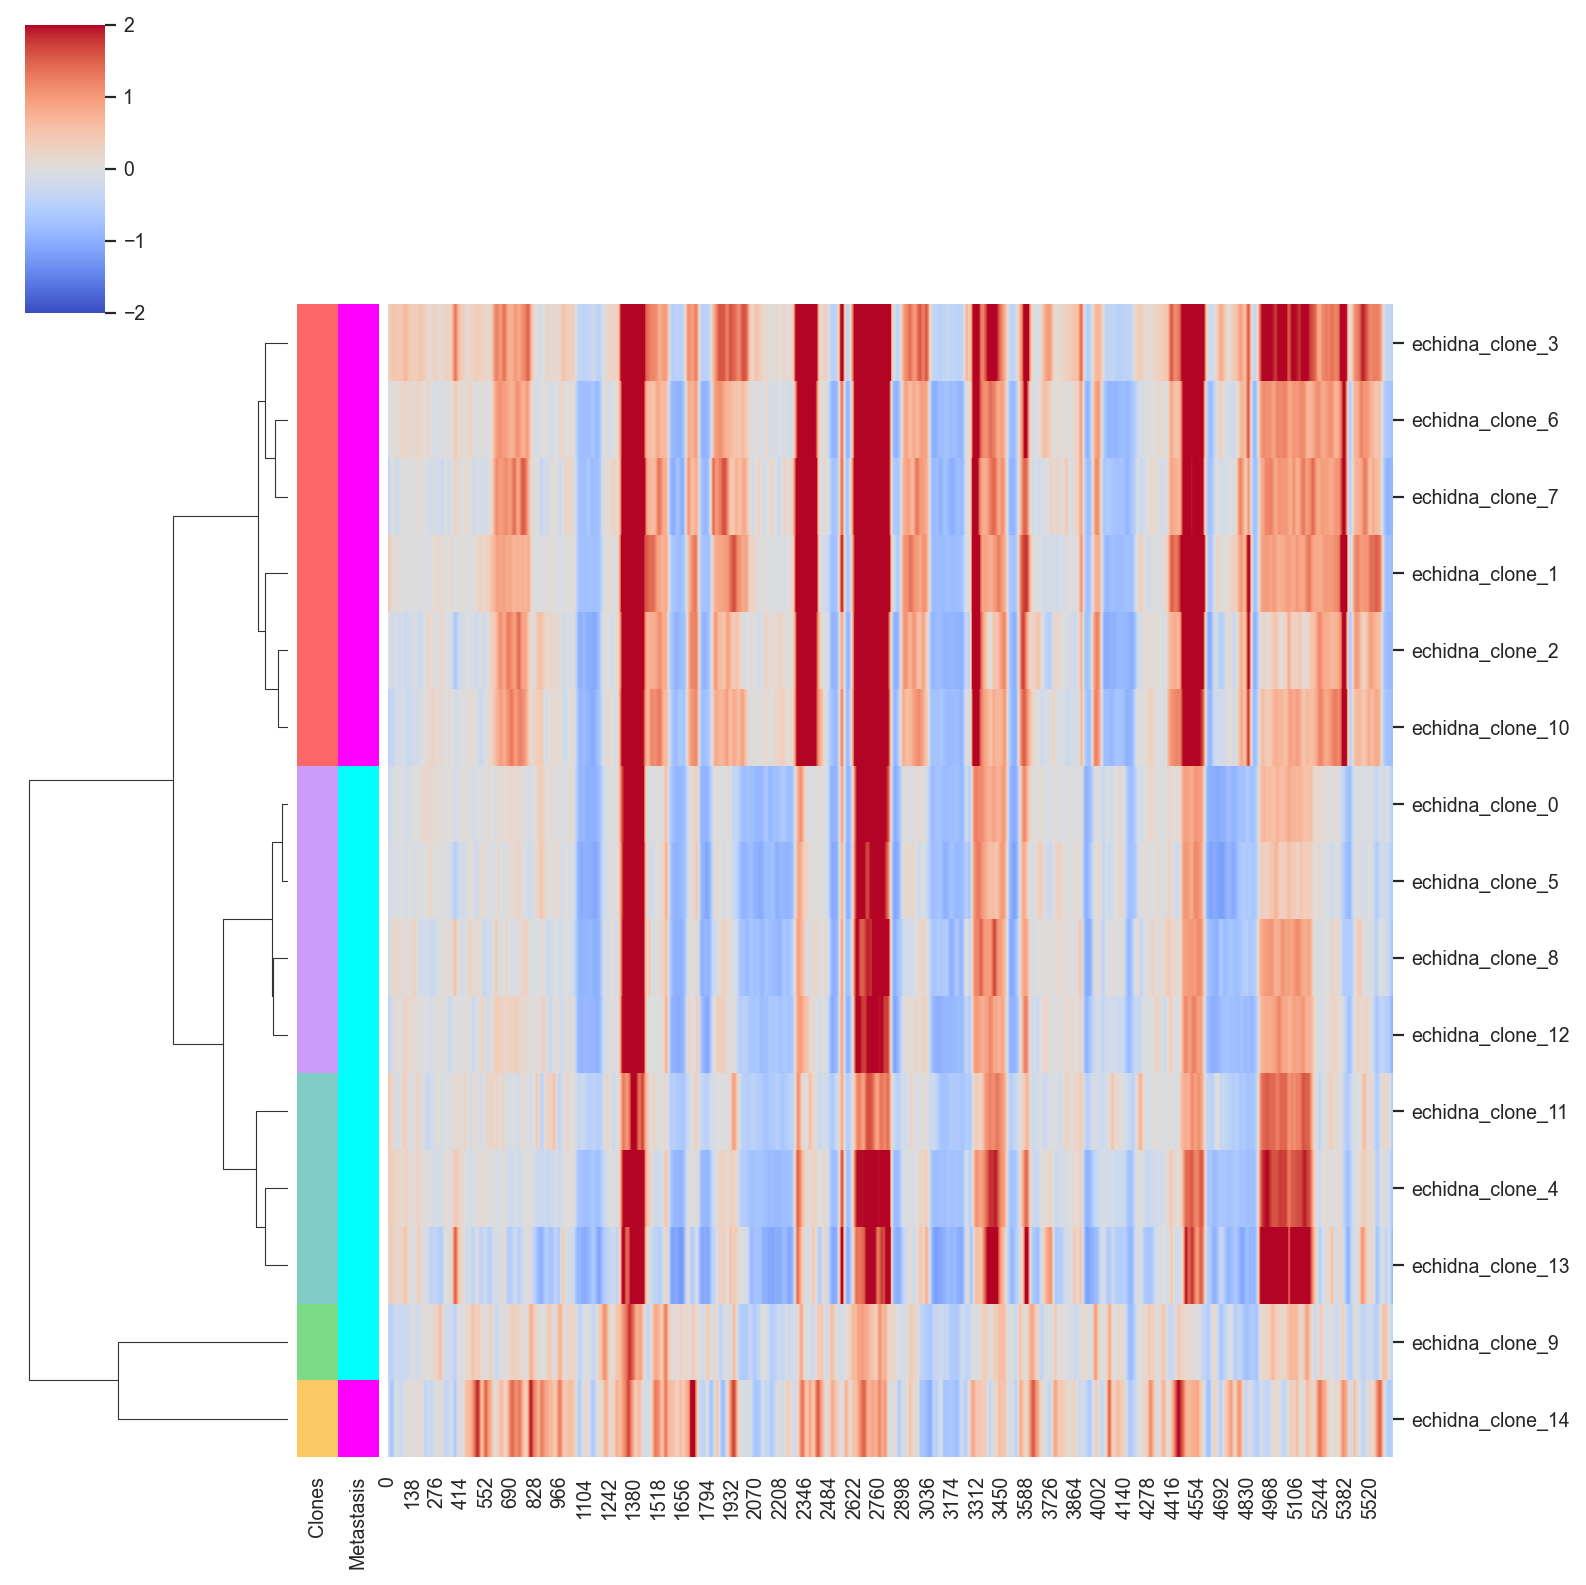

In [101]:
cl = sns.clustermap(pd.DataFrame(scipy.ndimage.gaussian_filter1d(cnvs.T, sigma=10),index=cnvs.columns), cmap='coolwarm', 
                    vmin=-2, vmax=2, col_cluster=False,
                    metric='correlation', row_colors=row_colors)
plt.savefig("clustermap_row_colors.pdf", bbox_inches='tight')

In [189]:
met_inds = [0,1,2,3,4,5,6,14]

/var/folders/ls/bynfxvkd45n7qyly8qv285pm0000gn/T/ipykernel_39546/2590747840.py:57: RuntimeWarning: Mean of empty slice.
  if smooth[met_inds,int(round(kde_x[left_indices[i]],0)):int(round(kde_x[right_indices[i]],0))].mean()>.5:
/Users/joyfan/miniconda3/envs/decipher-env/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
2025-07-13 20:56:11,126 | INFO : maxp pruned
2025-07-13 20:56:11,127 | INFO : LTSH dropped
2025-07-13 20:56:11,127 | INFO : cmap pruned
2025-07-13 20:56:11,127 | INFO : kern dropped
2025-07-13 20:56:11,129 | INFO : post pruned
2025-07-13 20:56:11,130 | INFO : PCLT dropped
2025-07-13 20:56:11,130 | INFO : JSTF dropped
2025-07-13 20:56:11,130 | INFO : DSIG dropped
2025-07-13 20:56:11,132 | INFO : GPOS pruned
2025-07-13 20:56:11,133 | INFO : GSUB pruned
2025-07-13 20:56:11,135 | INFO : glyf pruned
2025-07-13 20:56:11,136 | INFO : Added gid0 to subset
2025-07-13 20:56:11,136 | INF

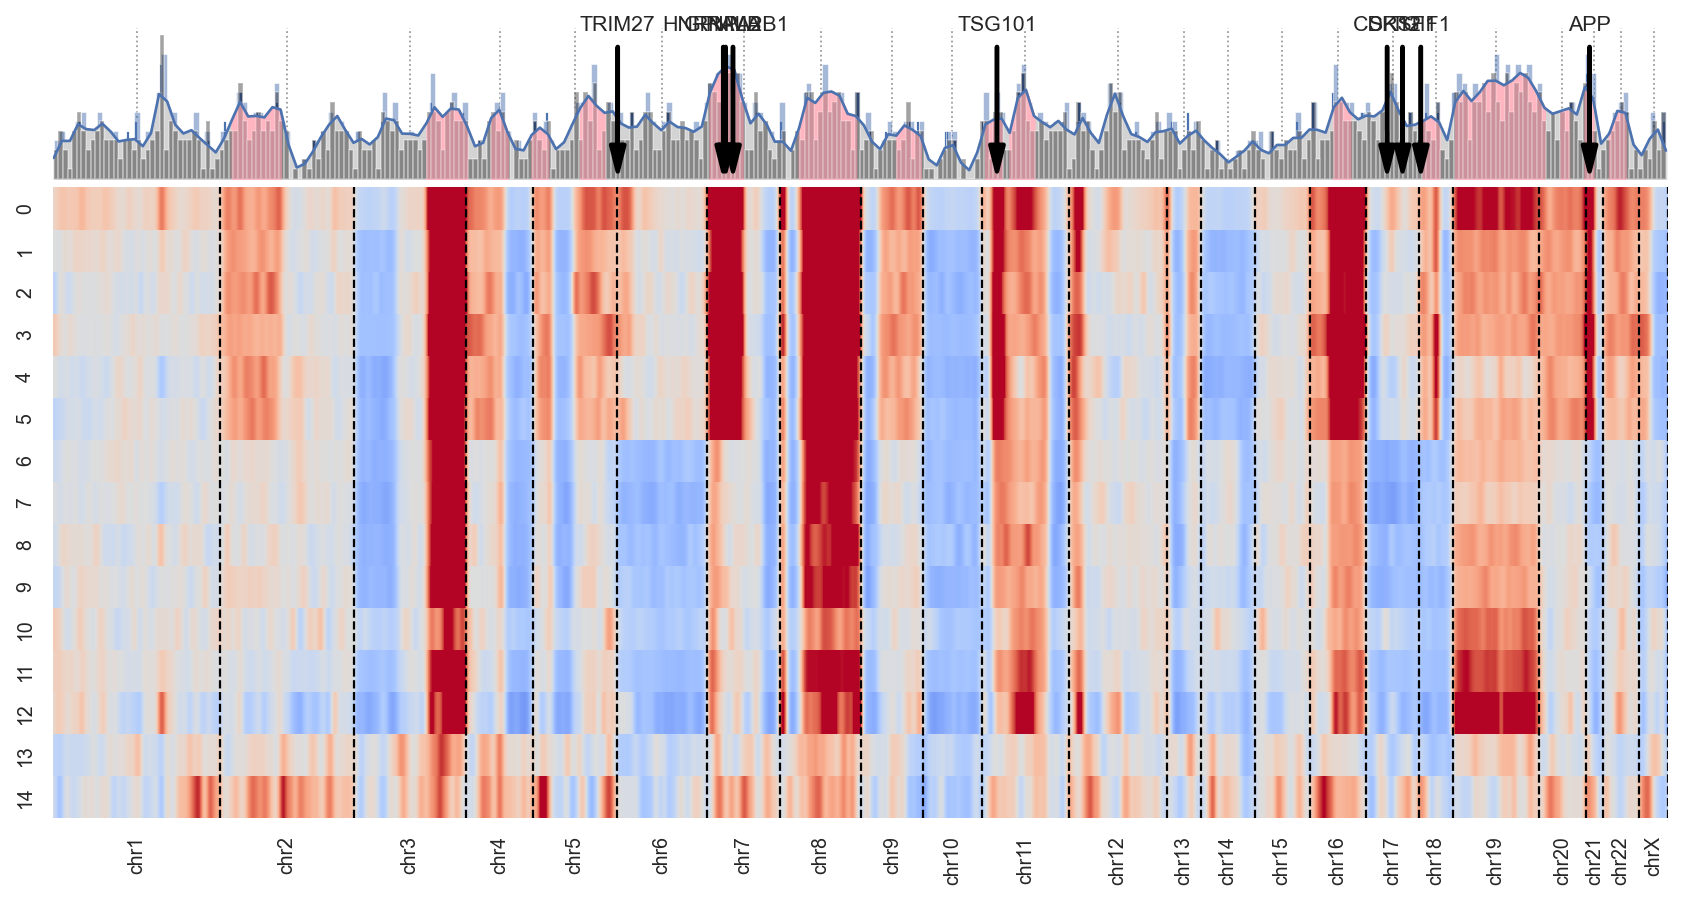

In [200]:
from scipy.signal import find_peaks
from scipy.signal import peak_widths
from adjustText import adjust_text

fig = plt.figure(figsize=(15,10))
ax1 = plt.subplot2grid((23,22), (3,1), colspan=19, rowspan=12)
ax2 = plt.subplot2grid((23,22), (0,1), colspan=19, rowspan=3,sharex = ax1)

smooth = scipy.ndimage.gaussian_filter1d(cnvs.T.loc[inds], sigma=10)
sns.heatmap(smooth, cmap='coolwarm', vmin=-2, vmax=2, ax=ax1, cbar=False)

# Rasterize the heatmap (which is a QuadMesh object)
for artist in ax1.collections:
    artist.set_rasterized(True)

genes = np.intersect1d(genes, cnvs.index)
draw_lines = [list(cnvs.index).index(i) for i in genes]

#sns.kdeplot(draw_lines, bw_adjust=.1, ax=ax2, fill=True, color="pink")

density = []
for gene in genes:
    density.append(list(cnvs.index).index(gene))
#get max height of histogram bars
counts, bin_edges, patches = plt.hist(density, bins=400)
ax_hist = sns.histplot(density, bins=300, kde=True, kde_kws=dict(bw_adjust=.05), ax=ax2)
# Extract KDE data
kde_line = ax_hist.get_lines()[0]  # The first line corresponds to the KDE
kde_x = kde_line.get_xdata()
kde_y = kde_line.get_ydata()

#plt.clf()   

#plt.plot(kde_x, kde_y)
ax2.fill_between(kde_x, 0, kde_y, color='lightgrey')


# Find peaks
peaks, _ = find_peaks(kde_y, prominence=.5)

# Find peak widths
results_full = peak_widths(kde_y, peaks, rel_height=0.4)  # Width at half prominence


# Interpolated x-coordinates for the widths
left_coords = results_full[2]
right_coords = results_full[3]

# Convert interpolated coordinates to indices
left_indices = np.round(left_coords).astype(int)
right_indices = np.round(right_coords).astype(int)

#figure out which peaks correspond to amps
hotspot_inds = []
for i in range(len(left_coords)):
    #COMPUTE ONLY IN METS
    if smooth[met_inds,int(round(kde_x[left_indices[i]],0)):int(round(kde_x[right_indices[i]],0))].mean()>.5:
        hotspot_inds.append(i)
        
peaks = peaks[hotspot_inds]
left_indices = left_indices[hotspot_inds]
right_indices = right_indices[hotspot_inds]


for i in range(len(left_indices)):
    ax2.fill_between(kde_x[left_indices[i]:right_indices[i]+1], 0, kde_y[left_indices[i]:right_indices[i]+1], color='lightpink')
ax2.hist(draw_lines, bins=350, color='black', alpha=.2)
ax2.set_yticks([])
ax2.tick_params(axis="x", which="both", bottom=False, top=False, labelbottom=False)
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)
ax2.spines["left"].set_visible(False)  # Remove left spine
ax2.spines["bottom"].set_visible(False)
ax2.set_ylabel(None)

chr_lines, chr_list, gen = eta_no_bin(cnvs)
ticklines = []
for i in range(len(chr_lines)):
    ax1.axvline(x=chr_lines[i], color='black', linestyle='--', linewidth=1)
    if i==0:
        ticklines.append(chr_lines[i]-.5*chr_lines[0])
        #plt.text(draw_lines[i]-.5*draw_lines[0], delta_wgs.T.shape[0]+.4, chr_list[i], color='black', fontsize=10, rotation=45)
    else:
        ticklines.append(chr_lines[i-1]+.5*(chr_lines[i]-chr_lines[i-1]))
        #plt.text(draw_lines[i-1]+.5*(draw_lines[i]-draw_lines[i-1]), delta_wgs.T.shape[0]+.4, chr_list[i], color='black', fontsize=10, rotation=45)
plt.xticks(ticklines, labels=chr_list, rotation=45)

texts = []
#for gene in met_relevant:
#    texts.append(ax2.text(list(cnvs.index).index(gene), 0, gene, rotation=45, fontsize=8, color='black'))    

for gene in met_relevant:
    gene_idx = list(cnvs.index).index(gene)

    plt.annotate(
        gene,
        xy=(gene_idx, 0),
        xytext=(gene_idx, 15),  # Move label upward (positive y)
        textcoords='data',      # Position relative to data coordinates
        ha='center',            # Center text horizontally
        va='bottom',            # Align text above the arrow tip
        arrowprops=dict(
            facecolor='black',
            shrink=0.05,
            width=.1,            # Width of arrow shaft
            headwidth=6,        # Width of arrow head
            edgecolor='black',
            linewidth=2         # Thickness of the arrow edge
        )
    )

for i in range(len(left_indices)):
    ax2.fill_between(kde_x[left_indices[i]:right_indices[i]+1], 0, kde_y[left_indices[i]:right_indices[i]+1], color='lightpink')
ax2.hist(draw_lines, bins=350, color='black', alpha=.2)
ax2.set_yticks([])
ax2.tick_params(axis="x", which="both", bottom=False, top=False, labelbottom=False)
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)
ax2.spines["left"].set_visible(False)  # Remove left spine
ax2.spines["bottom"].set_visible(False)
ax2.set_ylabel(None)

#adjust_text(texts,arrowprops=dict(arrowstyle='->', color='black'))

plt.savefig("mets_hotspots.pdf", bbox_inches="tight")

In [197]:
left, right = np.round(kde_x[left_indices]).astype(int), np.round(kde_x[right_indices]).astype(int)

In [198]:
hotspot_nr = []
for i in range(len(left)):
    print(np.intersect1d(cnvs.index[left[i]:right[i]], genes))
    hotspot_nr += list(np.intersect1d(cnvs.index[left[i]:right[i]], genes))

['ACTR2' 'ATRAID' 'AUP1' 'C1D' 'CALM2' 'CCT4' 'CCT7' 'CEBPZ' 'CEBPZOS'
 'COX7A2L' 'DCTN1' 'DGUOK' 'EPCAM' 'ERLEC1' 'ETAA1' 'FOXN2' 'GFPT1'
 'HADHA' 'LAPTM4A' 'MAP4K3-DT' 'MCFD2' 'MDH1' 'MOB1A' 'MPHOSPH10' 'MPV17'
 'MRPL33' 'MSH6' 'MTHFD2' 'MTIF2' 'NRBP1' 'OST4' 'PCBP1' 'PCBP1-AS1'
 'PEX13' 'PIGF' 'PNO1' 'PNPT1' 'PPM1G' 'PPP1CB' 'PPP4R3B' 'PREB' 'PREPL'
 'RAB1A' 'RHOB' 'RPS27A' 'RTKN' 'RTN4' 'SDC1' 'SF3B6' 'SLC30A6' 'SLC4A1AP'
 'SNRPG' 'SNX17' 'SRSF7' 'SUCLG1' 'TMEM214' 'TMSB10' 'TRMT61B' 'TTC32'
 'UBXN2A' 'WBP1' 'WDR43' 'YIPF4' 'YPEL5' 'ZFP36L2']
['AUP1' 'CCT7' 'DCTN1' 'DGUOK' 'MOB1A' 'MPHOSPH10' 'MTHFD2' 'PCBP1'
 'PCBP1-AS1' 'RTKN' 'SNRPG' 'SUCLG1' 'TMSB10' 'WBP1']
['ABCF3' 'ACTL6A' 'ALG3' 'AP2M1' 'B3GNT5' 'CLDN1' 'COMMD2' 'DNAJB11'
 'DNAJC19' 'EEF1AKMT4' 'EIF2A' 'EIF4A2' 'EIF4G1' 'FBXO45' 'GFM1' 'GOLIM4'
 'GPR87' 'KLHL24' 'LEKR1' 'LINC00886' 'LSG1' 'MAGEF1' 'MFSD1' 'MME'
 'MRPL47' 'MYNN' 'NCBP2' 'NCBP2AS2' 'NDUFB5' 'NLGN1' 'P2RY1' 'P3H2' 'PAK2'
 'PDCD10' 'PFN2' 'PLOD2' 'PSMD2' 'RFC4'

In [209]:
obs = adata.obs
obs[obs["timepoint"]=="mets"]

tumor_nontumor_minor_refined timepoint batch  \
index                                                                     
PA067_CTCGAAACAAGTCTAC-1-1                 Cancer cells      mets     1   
PA067_TACCTATCACCTCGTT-1-1                 Cancer cells      mets     1   
PA067_TAGACCAAGTGCCAGA-1-1                 Cancer cells      mets     1   
PA067_CTAATGGTCGTCCGTT-1-1                 Cancer cells      mets     1   
PA067_AAGGCAGAGATGTAAC-1-1                 Cancer cells      mets     1   
...                                                 ...       ...   ...   
PA067_ATCTGCCAGTAGTGCG-1-1                 Cancer cells      mets     1   
PA067_AACTCTTCAATGTTGC-1-1                 Cancer cells      mets     1   
PA067_GCGCAACTCTCAAGTG-1-1                 Cancer cells      mets     1   
PA067_CTACCCATCGCGCCAA-1-1                 Cancer cells      mets     1   
PA067_TTGCCGTTCCATGCTC-1-1                 Cancer cells      mets     1   

                            n_genes_by_counts  log1p_n_genes_by_counts  \
index                                                                    
PA067_CTCGAAACAAGTCTAC-1-1               6829                 8.829080   
PA067_TACCTATCACCTCGTT-1-1               6806                 8.825707   
PA067_TAGACCAAGTGCCAGA-1-1               6826                 8.828641   
PA067_CTAATGGTCGTCCGTT-1-1               6716                 8.812397   
PA067_AAGGCAGAGATGTAAC-1-1               7049                 8.860783   
...                                       ...                      ...   
PA067_ATCTGCCAGTAGTGCG-1-1                532                 6.278521   
PA067_AACTCTTCAATGTTGC-1-1                522                 6.259581   
PA067_GCGCAACTCTCAAGTG-1-1                558                 6.326149   
PA067_CTACCCATCGCGCCAA-1-1                521                 6.257668   
PA067_TTGCCGTTCCATGCTC-1-1                499                 6.214608   

                            total_counts  log1p_total_counts  \
index                                                          
PA067_CTCGAAACAAGTCTAC-1-1       32636.0           10.393202   
PA067_TACCTATCACCTCGTT-1-1       31931.0           10.371364   
PA067_TAGACCAAGTGCCAGA-1-1       30414.0           10.322691   
PA067_CTAATGGTCGTCCGTT-1-1       31914.0           10.370831   
PA067_AAGGCAGAGATGTAAC-1-1       31189.0           10.347853   
...                                  ...                 ...   
PA067_ATCTGCCAGTAGTGCG-1-1         733.0            6.598509   
PA067_AACTCTTCAATGTTGC-1-1         743.0            6.612041   
PA067_GCGCAACTCTCAAGTG-1-1         743.0            6.612041   
PA067_CTACCCATCGCGCCAA-1-1         713.0            6.570883   
PA067_TTGCCGTTCCATGCTC-1-1         699.0            6.551080   

                            pct_counts_in_top_50_genes  \
index                                                    
PA067_CTCGAAACAAGTCTAC-1-1                   16.714671   
PA067_TACCTATCACCTCGTT-1-1                   17.453259   
PA067_TAGACCAAGTGCCAGA-1-1                   18.182416   
PA067_CTAATGGTCGTCCGTT-1-1                   19.706085   
PA067_AAGGCAGAGATGTAAC-1-1                   14.139601   
...                                                ...   
PA067_ATCTGCCAGTAGTGCG-1-1                   25.511596   
PA067_AACTCTTCAATGTTGC-1-1                   29.475101   
PA067_GCGCAACTCTCAAGTG-1-1                   24.360700   
PA067_CTACCCATCGCGCCAA-1-1                   27.208976   
PA067_TTGCCGTTCCATGCTC-1-1                   27.610873   

                            pct_counts_in_top_100_genes  \
index                                                     
PA067_CTCGAAACAAGTCTAC-1-1                    21.987989   
PA067_TACCTATCACCTCGTT-1-1                    23.084150   
PA067_TAGACCAAGTGCCAGA-1-1                    24.860262   
PA067_CTAATGGTCGTCCGTT-1-1                    25.459046   
PA067_AAGGCAGAGATGTAAC-1-1                    19.445959   
...                                                 ...   
PA067_ATCTGCCAGTAGTGCG-1-1  

In [105]:
def enrich_sig(a):
    #adapted from https://davidbioinformatics.nih.gov/helps/functional_annotation.html
    res = pd.DataFrame()
    frac = []
    for s in wouters.columns:
        sig = [i for i in wouters[s] if not pd.isna(i)]
        
        lh = len(np.intersect1d(a, sig)) #number of signature genes in query list
        lt = len(sig) #length of gene signature
        ph = len(np.intersect1d(sig, exp_norm.index)) #number of signature genes in full data
        pt = exp_norm.shape[0] #length of full data
        
        table = [[lh, ph-lh],[lt-lh,pt-lt-(ph-lh)]]
        frac.append(lh/len(a))
        res = pd.concat((res, pd.DataFrame({s:scipy.stats.fisher_exact(table)})),axis=1)
    res = res.T
    res.columns = ["statistic","p-val"]
    res["frac"] = frac
    
    from statsmodels.stats.multitest import multipletests
    
    # Example p-values
    p_values = res["p-val"]
    
    # Bonferroni correction
    _, p_bonf, _, _ = multipletests(p_values, method='fdr_bh')
    res["p-val-adj"] = p_bonf
    return res

In [110]:
obs = adata.obs

exp_norm = pd.DataFrame()
df = adata.to_df()
for cl in np.unique(obs["leiden"]):
    exp_norm = pd.concat((exp_norm, pd.DataFrame(df.loc[obs[obs["leiden"]==cl].index].mean(axis=0),columns=[cl])),axis=1)

In [59]:
kinomo = pd.read_csv("brain_mets_metaprograms.csv", index_col=0, header=0).iloc[1:103,0:8]
kinomo.columns = kinomo.loc["Gene expression programs"]
kinomo.columns = [str(i)+":"+kinomo.columns[i] for i in range(kinomo.shape[1])]

In [61]:
kinomo = kinomo.drop(["Metaprograms","Gene expression programs"], axis=0)

In [100]:
pal = {
 '0:Cell Cycle': '#f8766d',
 '1:Cell Cycle': '#b79f00',
 '2:EMT': '#00ba38',
 '3:Proliferation': '#00bfc4',
 '4:Hypoxia': '#619cff',
 '5:Hypoxia': '#f564e3',
 '6:Neuronal/Differentiation': '#00a9ff',
 '7:Neuronal/Differentiation': '#ff61cc'
}

In [88]:
mp_origin = []
view = []
for mp in kinomo.columns:
    mp_origin +=[mp for i in range(len([i for i in kinomo[mp] if not pd.isna(i) and i in cnvs.index]))]
    view += [i for i in kinomo[mp] if not pd.isna(i) and i in cnvs.index]

In [94]:
mp_cnv = cnvs.loc[view]

(-0.05500000000000001,
 0.05500000000000001,
 -0.05500000000000001,
 0.05500000000000001)

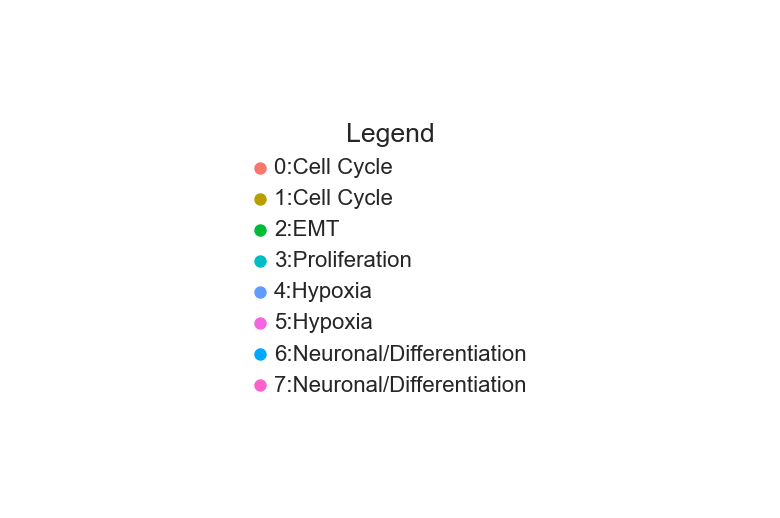

In [101]:
for i, (label, color) in enumerate(pal.items()):
    plt.scatter([], [], color=color, label=label)
plt.legend(title="Legend", loc='center', frameon=False, ncol=1, fontsize=10, title_fontsize=12)
plt.axis('off')

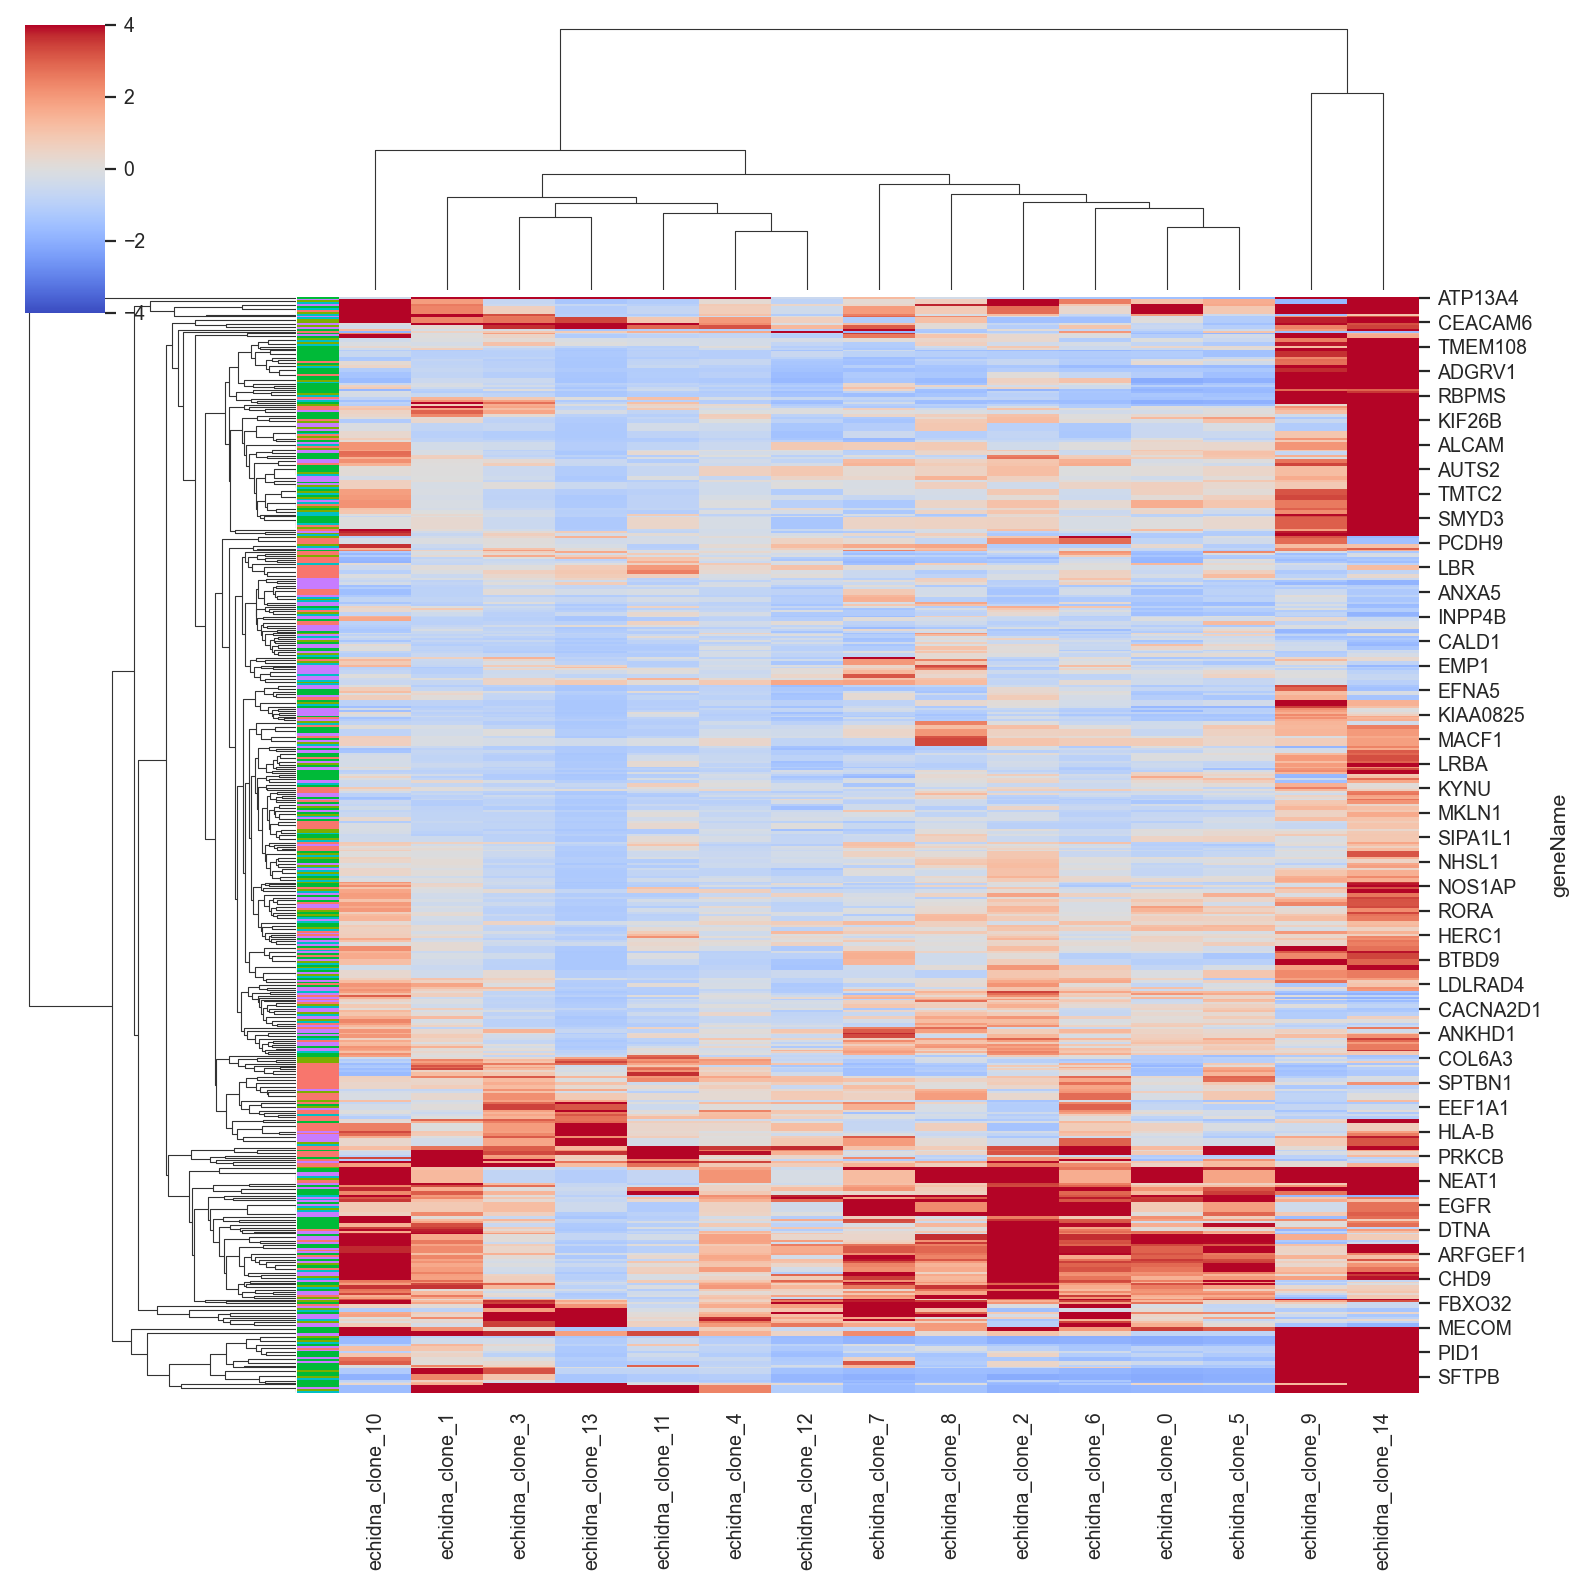

In [95]:
sns.clustermap(mp_cnv, cmap='coolwarm',vmax=4, vmin=-4, row_colors=[pal[i] for i in mp_origin])

In [107]:
hall = pd.read_csv("h.all.v2025.1.Hs.symbols.gmt", sep='\t', header=None, index_col=0).drop(1, axis=1).T

In [108]:
def enrich_sig(a):
    #adapted from https://davidbioinformatics.nih.gov/helps/functional_annotation.html
    res = pd.DataFrame()
    frac = []
    for s in hall.columns:
        sig = [i for i in hall[s] if not pd.isna(i)]
        
        lh = len(np.intersect1d(a, sig)) #number of signature genes in query list
        lt = len(sig) #length of gene signature
        ph = len(np.intersect1d(sig, exp_norm.index)) #number of signature genes in full data
        pt = exp_norm.shape[0] #length of full data
        
        table = [[lh, ph-lh],[lt-lh,pt-lt-(ph-lh)]]
        frac.append(lh/len(a))
        res = pd.concat((res, pd.DataFrame({s:scipy.stats.fisher_exact(table)})),axis=1)
    res = res.T
    res.columns = ["statistic","p-val"]
    res["frac"] = frac
    
    from statsmodels.stats.multitest import multipletests
    
    # Example p-values
    p_values = res["p-val"]
    
    # Bonferroni correction
    _, p_bonf, _, _ = multipletests(p_values, method='fdr_bh')
    res["p-val-adj"] = p_bonf
    return res

In [111]:
deg_res = enrich_sig(mets["names"])

2025-07-12 13:18:43,801 | INFO : maxp pruned
2025-07-12 13:18:43,801 | INFO : LTSH dropped
2025-07-12 13:18:43,802 | INFO : cmap pruned
2025-07-12 13:18:43,802 | INFO : kern dropped
2025-07-12 13:18:43,805 | INFO : post pruned
2025-07-12 13:18:43,805 | INFO : PCLT dropped
2025-07-12 13:18:43,805 | INFO : JSTF dropped
2025-07-12 13:18:43,806 | INFO : DSIG dropped
2025-07-12 13:18:43,808 | INFO : GPOS pruned
2025-07-12 13:18:43,809 | INFO : GSUB pruned
2025-07-12 13:18:43,812 | INFO : glyf pruned
2025-07-12 13:18:43,815 | INFO : Added gid0 to subset
2025-07-12 13:18:43,815 | INFO : Added first four glyphs to subset
2025-07-12 13:18:43,815 | INFO : Closing glyph list over 'GSUB': 49 glyphs before
2025-07-12 13:18:43,815 | INFO : Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'a', 'c', 'e', 'five', 'four', 'g', 'i', 'n', 'nine', 'nonmarkingreturn', 'one', 'percent', 'period', 'r', 's'

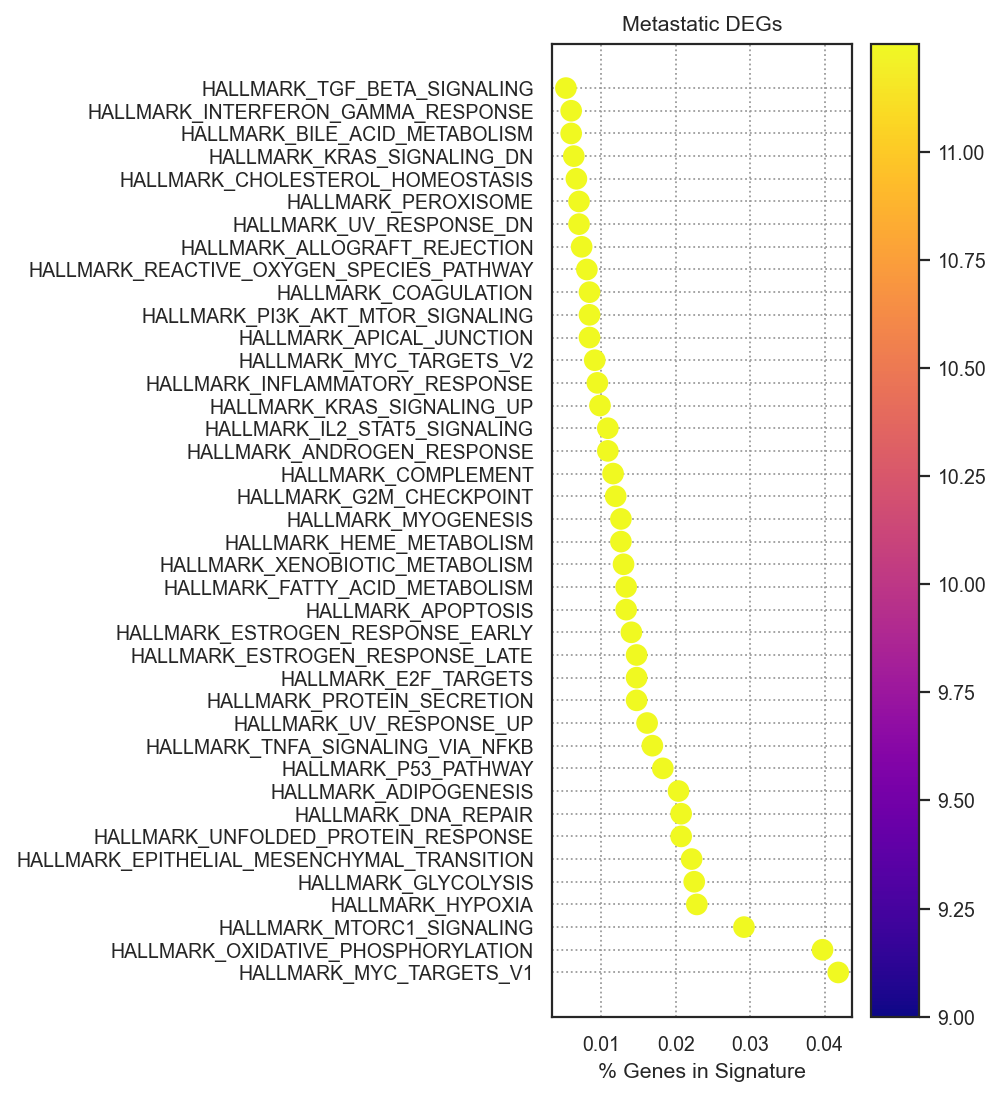

In [112]:
plt.figure(figsize=(3,8))
plot = deg_res[deg_res["p-val-adj"]<.05].sort_values(by='frac', ascending=False)
plot = plot.loc[[i for i in plot.index if "KEGG" not in i]].iloc[0:40]
plt.scatter(plot['frac'],[i for i in range(plot.shape[0])], c=-np.log10(plot["p-val-adj"]), s=80, vmax=10, cmap="plasma")
plt.yticks([i for i in range(plot.shape[0])], plot.index)
plt.title("Metastatic DEGs")
plt.xlabel("% Genes in Signature")
plt.colorbar()
plt.savefig("DEG_mets_hallmarks.pdf")

In [171]:
deg_res = enrich_sig(hotspot_nr)

2025-07-12 21:25:16,339 | INFO : maxp pruned
2025-07-12 21:25:16,340 | INFO : LTSH dropped
2025-07-12 21:25:16,340 | INFO : cmap pruned
2025-07-12 21:25:16,340 | INFO : kern dropped
2025-07-12 21:25:16,343 | INFO : post pruned
2025-07-12 21:25:16,343 | INFO : PCLT dropped
2025-07-12 21:25:16,343 | INFO : JSTF dropped
2025-07-12 21:25:16,344 | INFO : DSIG dropped
2025-07-12 21:25:16,346 | INFO : GPOS pruned
2025-07-12 21:25:16,347 | INFO : GSUB pruned
2025-07-12 21:25:16,349 | INFO : glyf pruned
2025-07-12 21:25:16,351 | INFO : Added gid0 to subset
2025-07-12 21:25:16,351 | INFO : Added first four glyphs to subset
2025-07-12 21:25:16,352 | INFO : Closing glyph list over 'GSUB': 53 glyphs before
2025-07-12 21:25:16,352 | INFO : Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'a', 'c', 'e', 'eight', 'five', 'four', 'g', 'i', 'n', 'nine', 'nonmarkingreturn', 'o', 'one', 'p', 'percent',

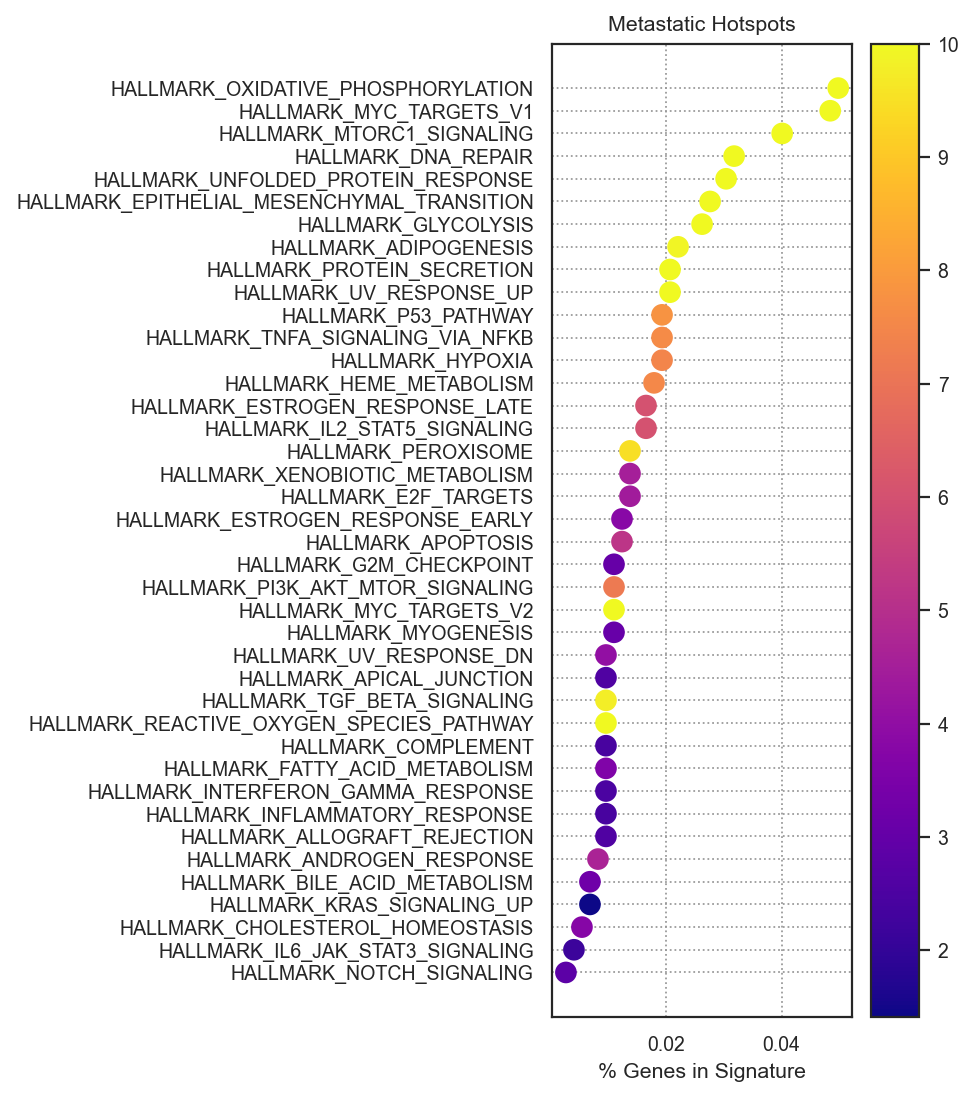

In [172]:
plt.figure(figsize=(3,8))
plot = deg_res[deg_res["p-val-adj"]<.05].sort_values(by='frac', ascending=False)
plot = plot.loc[[i for i in plot.index if "KEGG" not in i]].iloc[0:40]
plt.scatter(plot['frac'],np.flip([i for i in range(plot.shape[0])]), c=-np.log10(plot["p-val-adj"]), s=80, vmax=10, cmap="plasma")
plt.yticks(np.flip([i for i in range(plot.shape[0])]), plot.index)
plt.title("Metastatic Hotspots")
plt.xlabel("% Genes in Signature")
plt.colorbar()
plt.savefig("hotspot_mets_hallmarks.pdf", bbox_inches='tight')

In [126]:
from statsmodels.stats.multitest import multipletests
import tqdm
def permutation_test(df, labels, label_0='label_0', label_1='label_1', num_permutations=1000):
    # Convert string labels to binary labels (0 and 1)
    labels = labels.map({label_0: 0, label_1: 1})
    
    # Function to calculate the test statistic (difference in means)
    def calculate_statistic(df, labels):
        return df[labels == 1].mean() - df[labels == 0].mean()

    # Calculate the observed test statistic
    observed_stats = calculate_statistic(df, labels).abs()
    permuted_stats = np.zeros((num_permutations, observed_stats.shape[0]))

    # Perform permutation test
    for i in tqdm.tqdm((range(num_permutations))):
        permuted_labels = np.random.permutation(labels)
        permuted_stat = calculate_statistic(df, permuted_labels).abs()
        permuted_stats[i, :] = permuted_stat.values

    # Calculate p-values
    p_values = (np.sum(permuted_stats >= observed_stats.values, axis=0) + 1) / (num_permutations + 1)
    
    return pd.Series(p_values, index=df.columns)

def fdr_correction(p_values, alpha=0.05):
    rejected, pvals_corrected, _, _ = multipletests(p_values, alpha=alpha, method='fdr_bh')
    return pd.Series(pvals_corrected, index=p_values.index)

In [116]:
# positive = enriched in label_1, negative = enriched in label_0
def permutation_test_signed(df, labels, label_0='label_0', label_1='label_1', num_permutations=1000):
    # Convert string labels to binary labels (0 and 1)
    labels = labels.map({label_0: 0, label_1: 1})
    
    # Function to calculate the test statistic (difference in means)
    def calculate_statistic(df, labels):
        return df[labels == 1].mean() - df[labels == 0].mean()

    # Calculate the observed test statistic
    observed_stats = calculate_statistic(df, labels)
    permuted_stats = np.zeros((num_permutations, observed_stats.shape[0]))

    # Perform permutation test
    for i in tqdm.tqdm((range(num_permutations))):
        permuted_labels = np.random.permutation(labels)
        permuted_stat = calculate_statistic(df, permuted_labels)
        permuted_stats[i, :] = permuted_stat.values

    # Calculate two-sided p-values
    p_values = np.mean(np.abs(permuted_stats) >= np.abs(observed_stats.values), axis=0)
    
    # Create a DataFrame with test statistics and p-values
    results_df = pd.DataFrame({
        'test_statistic': observed_stats,
        'p_value': p_values
    }, index=df.columns)
    
    return results_df

In [124]:
metas_dict = metas_dict.T
metas_dict.index = cnvs.columns

In [127]:
res = permutation_test_signed(cnvs.T, labels=metas_dict[0], label_0="primary", label_1="mets", num_permutations=1000) # ties after 10K permutations
res

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1375.88it/s]


test_statistic  p_value
geneName                         
MEF2D          -0.354794    0.332
ATP5IF1        -0.461032    0.401
INTS3           0.325264    0.143
KIF26B          0.786507    0.374
CLK2            0.054056    0.819
...                  ...      ...
ATP11C         -0.009854    0.927
FMR1            0.041914    0.773
MTM1            0.173588    0.604
MTMR1          -0.107591    0.348
CD99L2          0.269701    0.403

[5646 rows x 2 columns]

In [128]:
# pval_corrected = fdr_correction(pval, alpha=0.05)
res['p_value_adj'] = fdr_correction(res['p_value'], alpha=0.05)

res = res[res["p_value_adj"]<.05]

In [133]:
mets_intrinsic = res.loc[np.intersect1d(mets['names'], res.index)]
mets_intrinsic = mets_intrinsic[mets_intrinsic["test_statistic"]>0]

2025-07-12 22:58:43,870 | INFO : maxp pruned
2025-07-12 22:58:43,871 | INFO : LTSH dropped
2025-07-12 22:58:43,871 | INFO : cmap pruned
2025-07-12 22:58:43,872 | INFO : kern dropped
2025-07-12 22:58:43,874 | INFO : post pruned
2025-07-12 22:58:43,874 | INFO : PCLT dropped
2025-07-12 22:58:43,875 | INFO : JSTF dropped
2025-07-12 22:58:43,875 | INFO : DSIG dropped
2025-07-12 22:58:43,877 | INFO : GPOS pruned
2025-07-12 22:58:43,878 | INFO : GSUB pruned
2025-07-12 22:58:43,880 | INFO : glyf pruned
2025-07-12 22:58:43,882 | INFO : Added gid0 to subset
2025-07-12 22:58:43,883 | INFO : Added first four glyphs to subset
2025-07-12 22:58:43,883 | INFO : Closing glyph list over 'GSUB': 30 glyphs before
2025-07-12 22:58:43,883 | INFO : Glyph names: ['.notdef', '.null', 'G', 'H', 'M', 'S', 'a', 'c', 'e', 'eight', 'five', 'four', 'g', 'i', 'minus', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'percent', 'period', 'r', 's', 'six', 'space', 't', 'two', 'u', 'zero']
2025-07-12 22:58:43,884 | INFO : Glyp

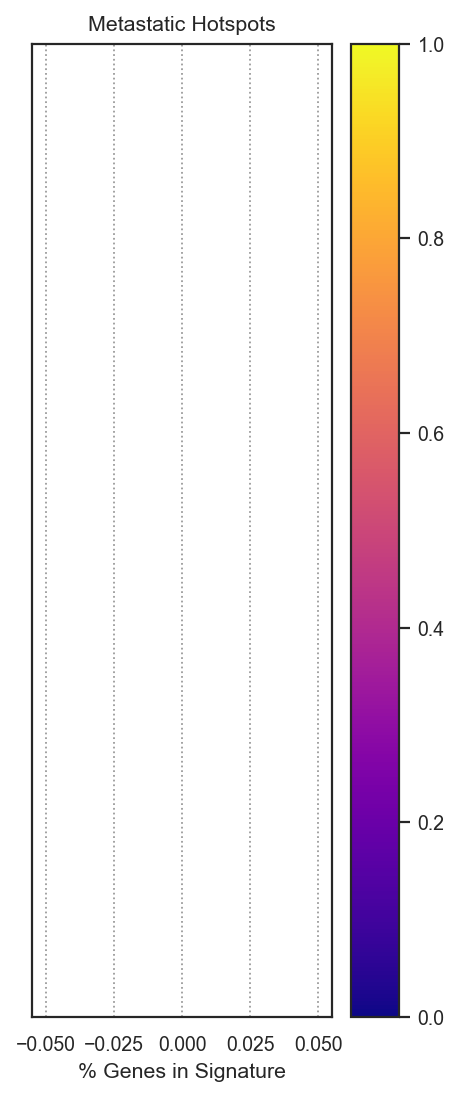

In [176]:
deg_res = enrich_sig(mets_intrinsic)
plt.figure(figsize=(3,8))
plot = deg_res[deg_res["p-val-adj"]<.05].sort_values(by='frac', ascending=False)
plot = plot.loc[[i for i in plot.index if "KEGG" not in i]].iloc[0:40]
plt.scatter(plot['frac'],np.flip([i for i in range(plot.shape[0])]), c=-np.log10(plot["p-val-adj"]), s=80, vmax=10, cmap="plasma")
plt.yticks(np.flip([i for i in range(plot.shape[0])]), plot.index)
plt.title("Metastatic Hotspots")
plt.xlabel("% Genes in Signature")
plt.colorbar()
plt.savefig("intrinsic_mets_hallmarks.pdf", bbox_inches='tight')

In [139]:
for i in mets_intrinsic.index:
    print(i)

AFG3L2
APP
ARFGAP3
ATP5PF
ATP5PO
C1GALT1
CBX3
CCNC
CCT8
CDK12
CDK13
CFAP298
CLTC
COA1
COQ9
CRLS1
CRNDE
CRYZL1
CSNK2B
CYB5B
DBNL
DDX56
DHX16
DNAJA3
DNAJC24
DYNC1LI2
EEF1E1
EIF1AX
EIF2S2
EIF3M
ELP2
ESCO1
ESF1
ETAA1
EVA1C
FIGNL1
FOXN2
GABPA
GART
GGCT
GNL1
GPNMB
GUF1
HADHA
HIBADH
HNRNPA2B1
IFNAR1
IFNGR2
IL10RB
IMMP1L
INO80C
KLHL7
LACTB2
LANCL2
LINC00667
LTN1
LYRM2
MALSU1
MBTPS1
MOCOS
MRPL32
NAE1
NAPG
NDUFV2
NIPSNAP2
NOL3
NT5C3A
NUP42
OCIAD1
OSTM1
PAXBP1
PEX13
PLEKHA8
PNPT1
POLM
PPIL4
PRKAA1
PRRC1
PSMD11
PSMD3
PSMD5
PSME3
PSMG2
PWWP2A
RALA
RNF138
RPP21
RPRD1A
RWDD1
SCAF4
SLC30A9
SLC35B3
SMARCE1
SNHG15
SNX13
SON
SRSF1
SRSF2
STARD3NL
SUCLG1
SYNJ1
TAF15
TAX1BP1
TERF2IP
TGIF1
TMED4
TMEM14B
TMEM267
TMEM50B
TPGS2
TRADD
TRAPPC8
TRIM27
TRIQK
TSG101
TTC1
UBE2J1
UBE2W
UCHL3
UQCC2
URB1
USP16
VAPA
VTA1
WBP1
ZNF24
ZNF397


In [179]:
met_relevant = ['APP', 'CDK12', 'GPNMB', 'HNRNPA2B1', 'RALA', 'SRSF1', 'TGIF1', 'TRIM27', 'TSG101']

In [202]:
for i in met_relevant:
    if i not in np.asarray(mets_intrinsic.index).flatten():
        print(i)

2025-07-13 20:40:48,197 | INFO : maxp pruned
2025-07-13 20:40:48,198 | INFO : LTSH dropped
2025-07-13 20:40:48,198 | INFO : cmap pruned
2025-07-13 20:40:48,199 | INFO : kern dropped
2025-07-13 20:40:48,201 | INFO : post pruned
2025-07-13 20:40:48,201 | INFO : PCLT dropped
2025-07-13 20:40:48,202 | INFO : JSTF dropped
2025-07-13 20:40:48,202 | INFO : DSIG dropped
2025-07-13 20:40:48,204 | INFO : GPOS pruned
2025-07-13 20:40:48,205 | INFO : GSUB pruned
2025-07-13 20:40:48,208 | INFO : glyf pruned
2025-07-13 20:40:48,210 | INFO : Added gid0 to subset
2025-07-13 20:40:48,210 | INFO : Added first four glyphs to subset
2025-07-13 20:40:48,211 | INFO : Closing glyph list over 'GSUB': 44 glyphs before
2025-07-13 20:40:48,211 | INFO : Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'D', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'R', 'S', 'T', 'a', 'c', 'd', 'e', 'eight', 'five', 'four', 'g', 'h', 'i', 'l', 'm', 'minus', 'n', 'nine', 'nonmarkingreturn', 'o', 'one', 'period', 'seven', 'six', 

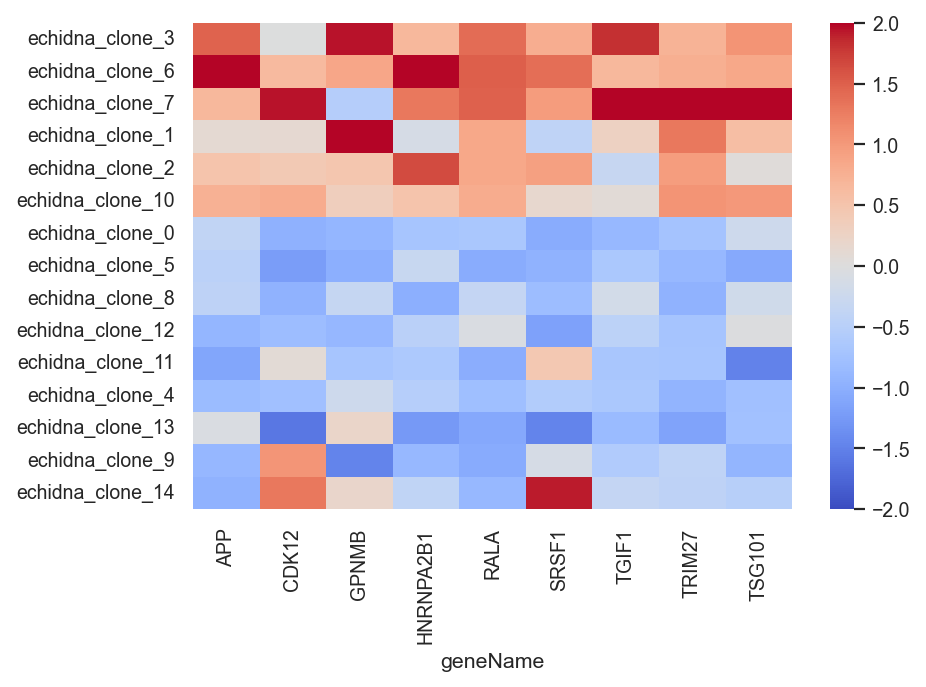

In [180]:
sns.heatmap(scipy.stats.zscore(cnvs.loc[met_relevant][inds].T,axis=0), cmap='coolwarm',vmin=-2, vmax=2)
plt.savefig("relevant.pdf")

In [181]:
adata.obs["met_sig"] = adata.to_df()[met_relevant].mean(axis=1)

2025-07-13 20:41:39,881 | INFO : maxp pruned
2025-07-13 20:41:39,881 | INFO : LTSH dropped
2025-07-13 20:41:39,882 | INFO : cmap pruned
2025-07-13 20:41:39,882 | INFO : kern dropped
2025-07-13 20:41:39,884 | INFO : post pruned
2025-07-13 20:41:39,885 | INFO : PCLT dropped
2025-07-13 20:41:39,885 | INFO : JSTF dropped
2025-07-13 20:41:39,885 | INFO : DSIG dropped
2025-07-13 20:41:39,887 | INFO : GPOS pruned
2025-07-13 20:41:39,889 | INFO : GSUB pruned
2025-07-13 20:41:39,891 | INFO : glyf pruned
2025-07-13 20:41:39,893 | INFO : Added gid0 to subset
2025-07-13 20:41:39,893 | INFO : Added first four glyphs to subset
2025-07-13 20:41:39,894 | INFO : Closing glyph list over 'GSUB': 22 glyphs before
2025-07-13 20:41:39,894 | INFO : Glyph names: ['.notdef', '.null', 'A', 'M', 'P', 'U', 'e', 'eight', 'four', 'g', 'i', 'm', 'nonmarkingreturn', 'one', 'period', 's', 'six', 'space', 't', 'two', 'underscore', 'zero']
2025-07-13 20:41:39,894 | INFO : Glyph IDs:   [0, 1, 2, 3, 17, 19, 20, 21, 23, 25

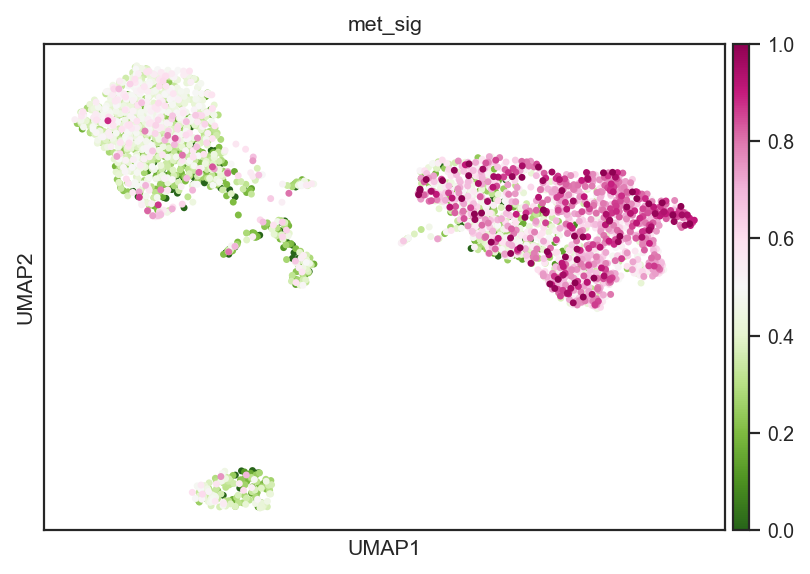

In [182]:
sc.pl.umap(adata, color='met_sig', cmap='PiYG_r', vmax=1, save='met_sig.pdf')